In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

In [ ]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, tol=1e-8, n_init=8, max_iter=1000)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    distances = []
    for i in range(4):
        line_start = rectangle[i]
        line_end = rectangle[(i + 1) % 4]
        distances.append(np.mean([distance_to_line(point, line_start, line_end) for point in points]))
    closest_side = np.argmin(distances)
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    # Find the angle of the closest side to make it parallel to the x-axis
    closest_line_start = rectangle[closest_side]
    closest_line_end = rectangle[(closest_side + 1) % 4]
    
    # Debugging: Print the coordinates of the closest line
    print(f"Closest line start: {closest_line_start}, end: {closest_line_end}")
    
    angle = np.arctan2(closest_line_end[1] - closest_line_start[1], closest_line_end[0] - closest_line_start[0])
    
    # Debugging: Print the initial calculated angle
    print(f"Initial calculated angle: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Ensure the longer side is at the top (if not, adjust the angle by 90 degrees)
    if rectangle[1][0] < rectangle[1][1]:
        angle += np.pi / 2
        print(f"Adjusted angle by 90 degrees: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Determine if the closest edge is the top or bottom edge
    if closest_line_start[1] < closest_line_end[1]:  # If the closest side is the bottom side
        angle += np.pi  # Rotate by 180 degrees to move it to the top
        print(f"Adjusted angle by 180 degrees (for bottom side): {angle} radians ({np.degrees(angle)} degrees)")
    
    final_angle = -angle  # Negate to rotate in the correct direction
    
    # Debugging: Print the final rotation angle
    print(f"Final rotation angle: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    return final_angle

def adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side):
    """
    Adjust the final orientation of the image by comparing the y-values of the closest side 
    before and after rotating by an additional 180 degrees.
    """
    # Calculate the y-values of the closest edge
    closest_line_start = rotated_rect[closest_side]
    closest_line_end = rotated_rect[(closest_side + 1) % 4]
    avg_y_before = (closest_line_start[1] + closest_line_end[1]) / 2
    
    # Perform a 180-degree rotation
    rotated_data_180 = rotate_points(rotated_com, np.pi, find_center_of_rectangle(rotated_rect))
    rotated_rect_180 = rotate_points(rotated_rect, np.pi, find_center_of_rectangle(rotated_rect))
    
    # Calculate the y-values of the rotated edge after the 180-degree rotation
    closest_line_start_180 = rotated_rect_180[closest_side]
    closest_line_end_180 = rotated_rect_180[(closest_side + 1) % 4]
    avg_y_after = (closest_line_start_180[1] + closest_line_end_180[1]) / 2
    
    # Compare the average y-values and choose the orientation with the higher y-value
    if avg_y_after < avg_y_before:
        print("Adjusting by 180 degrees")
        return rotated_data_180, rotated_rect_180, rotation_angle + np.pi
    else:
        return rotated_com, rotated_rect, rotation_angle

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points

def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)

def find_robot(rotated_com):
    
    #finding the center of the rectangle
    center_x, center_y = find_center_of_rectangle(rotated_com)
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com

def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.grid(False)
    plt.show()

    return ratio


In [ ]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    
    # Adjust the final orientation if needed
    rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
    if (rotation_angle != final_angle):
        #totae the data points by 180 degrees
        rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
    print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Final Adjusted Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)
    
    

    return ratio


Starting process_origami_ratio
Data collected:
             x          y
0  111.875267  60.029800
1  111.827614  60.045071
2  111.803627  60.154224
3  111.851440  60.342262
4  111.837921  60.320156


/tmp/ipykernel_8556/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


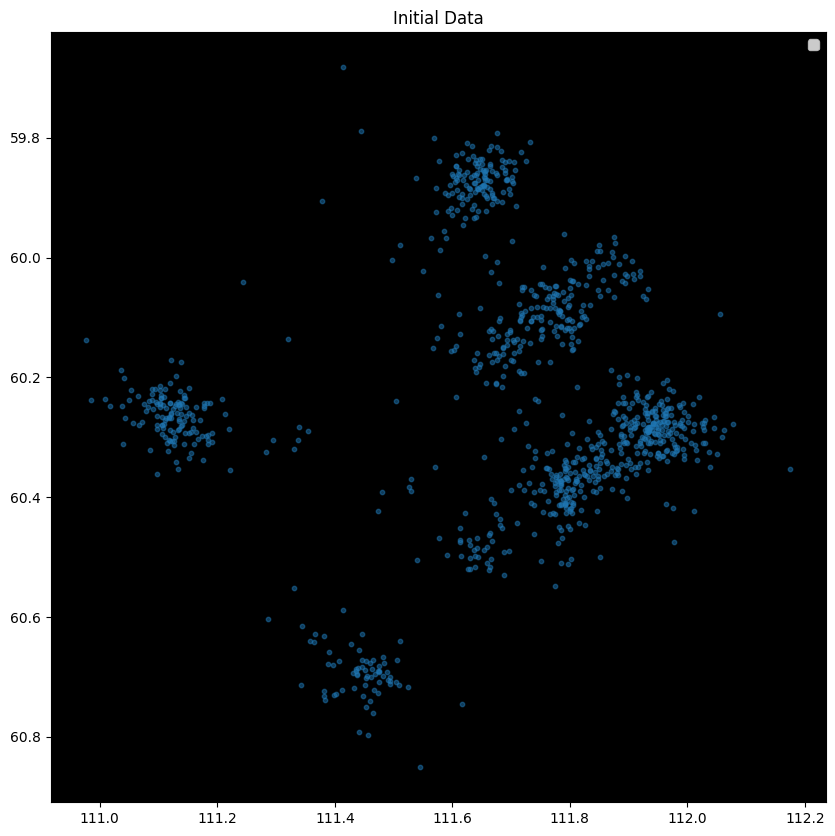

K-Means labels:
 [7 7 7 5 5 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 7 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 7 7 4 7 7 7 7 4 4 7 7 7 4 0 0 0 0 7
 7 7 7 7 7 7 7 7 7 7 2 2 2 3 3 3 3 3 5 5 2 2 2 2 2 2 2 2 2 2 2 7 7 7 7 4 5
 5 1 1 1 1 1 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 1 6 5 1 1 1 1 1 1 1 1 1 1 1 4 5 5 1 1 6 0 1 1 2 2 2 2 0 0 5
 5 5 5 0 2 2 5 5 5 5 5 5 1 1 5 5 0 0 0 0 0 0 2 4 4 5 5 1 1 1 1 1 1 1 5 1 5
 1 5 5 1 5 5 5 5 7 4 4 4 4 4 4 4 4 4 4 7 7 7 7 5 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 5 5 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 6 6 5 6 6 6 6 7
 7 2 2 2 0 0 0 0 0 0 0 7 7 4 4 4 1 1 1 6 6 6 6 6 6 6 6 6 0 0 0 0 0 4 0 0 0
 0 2 2 5 5 6 6 6 6 6 6 6 6 6 6 6 6 3 3 2 2 2 2 2 2 2 4 4 4 4 4 4 6 2 1 1 1
 5 5 5 4 4 4 4 2 2 2 2 2 2 2 2 2 2 0 2 7 7 7 7 7 7 3 3 3 3 0 1 1 1 1 1 3 3
 2 4 7 7 7 6 5 5 4 0 0 5 5 5 5 1 1 0 0 7 2 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 7 1 1 1 1 4 4
 4 4 4 6

/tmp/ipykernel_8556/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


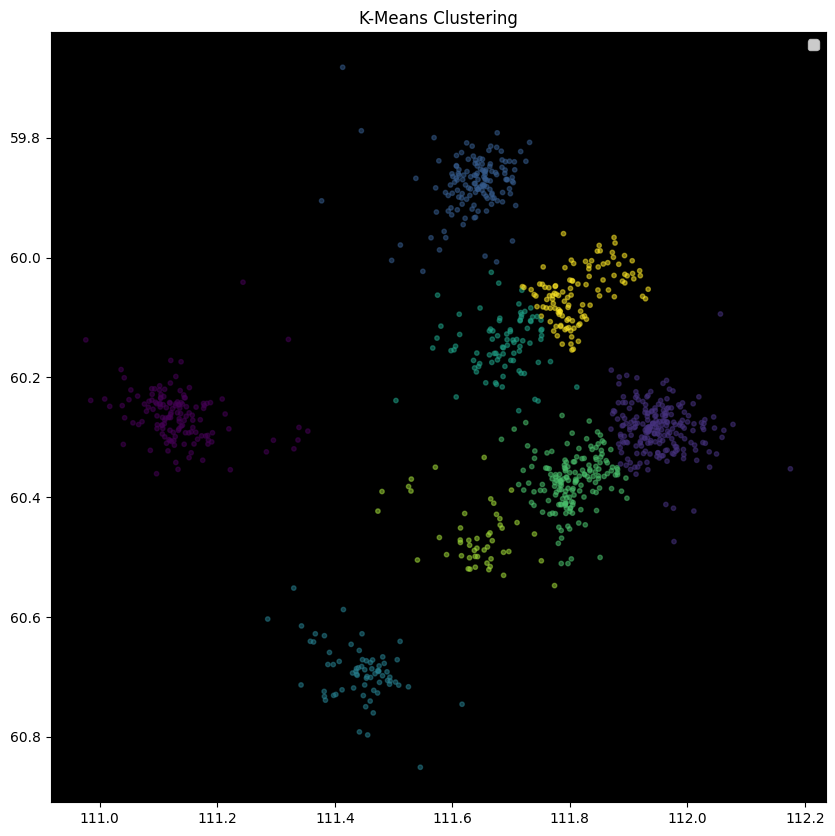

Centers of Mass (COM):
 [(np.float32(111.1327), np.float32(60.26338)), (np.float32(111.94994), np.float32(60.286213)), (np.float32(111.6368), np.float32(59.877396)), (np.float32(111.443954), np.float32(60.693012)), (np.float32(111.685936), np.float32(60.144897)), (np.float32(111.80507), np.float32(60.373333)), (np.float32(111.6388), np.float32(60.46383)), (np.float32(111.81368), np.float32(60.061646))]


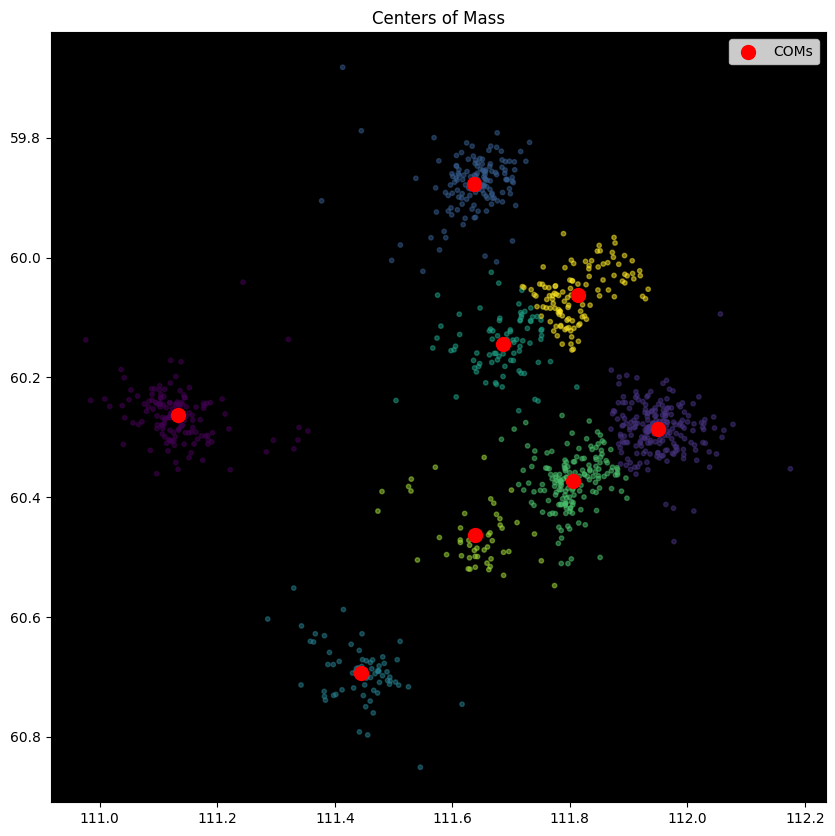

Minimum Bounding Rectangle:
 [[111.98178101  60.28120422]
 [111.65936279  59.86011505]
 [111.121521    60.27193069]
 [111.44393921  60.69301987]]
Closest side of bounding rectangle:
 3
Closest line start: [111.44393921  60.69301987], end: [111.98178101  60.28120422]
Initial calculated angle: -0.6534621121495734 radians (-37.44062109787503 degrees)
Final rotation angle: 0.6534621121495734 radians (37.44062109787503 degrees)
Rotation angle:
 0.6534621121495734
Rotated Data:
 [[112.18960342  60.42865532]
 [112.14248418  60.41180941]
 [112.05708023  60.4838932 ]
 [111.98072777  60.66225986]
 [111.98343288  60.63648902]]
Rotated Centers of Mass (COM):
 [[111.45801469  60.16267569]
 [112.09301223  60.67764146]
 [112.09291938  60.16267663]
 [111.44395596  60.69302309]
 [111.96930566  60.4049388 ]
 [111.92502049  60.65873848]
 [111.73799079  60.62951047]
 [112.12134648  60.41650021]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 3.7950547657393665 radians (217.44062109787504 

/tmp/ipykernel_8556/2768879537.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


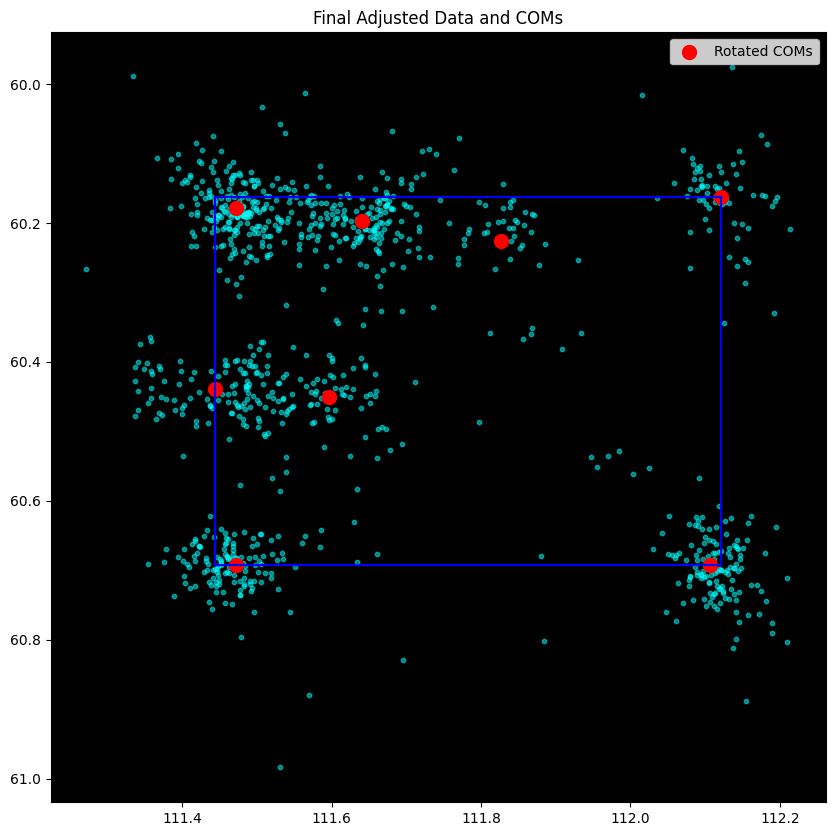

Second Highest COM:
 [111.44393002  60.43919096]
Right Most COM:
 [112.12132053  60.16266809]
Second Right Most COM:
 [112.1072618   60.69301548]
Robot COM:
 [111.59597084  60.45075237]


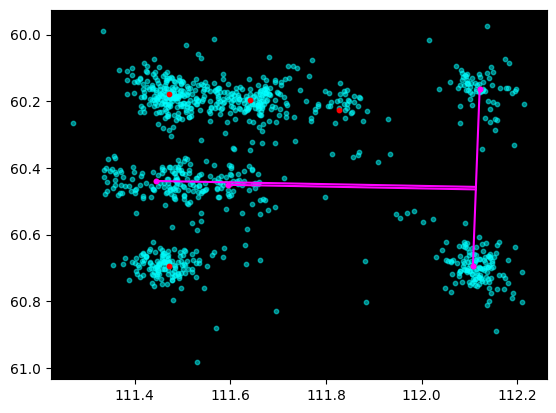

Ratio:
 0.7726364395401488


In [ ]:
ratio = process_origami_ratio('data/test_1.hdf5', 8)

In [ ]:
def generate_ratio_histogram(ratios, bins=10, title="Histogram of Ratios", xlabel="Ratio", ylabel="Frequency"):
    """
    Generates a histogram of the provided ratios.
    
    :param ratios: List of ratio values to plot.
    :param bins: Number of bins for the histogram.
    :param title: Title of the histogram plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.hist(ratios, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    

def plot_ratio_points_and_lines(ratios, title="Points and Lines Plot of Ratios", xlabel="Index", ylabel="Ratio"):
    """
    Plots points for each ratio and connects them with lines to visualize peaks.
    
    :param ratios: List of ratio values to plot.
    :param title: Title of the plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(20, 12))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Plotting the points
    plt.plot(range(len(ratios)), ratios, 'o-', color='red', markersize=8, linewidth=2)
    
    # Annotate the peak points
    max_ratio = max(ratios)
    min_ratio = min(ratios)
    
    for i, ratio in enumerate(ratios):
        plt.annotate(f"{ratio:.6f}", (i, ratio), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


def process_multiple_origami_ratio(filename, k):
    print("Starting process_multiple_origami_ratio")
    
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    ratios = []  # List to store the ratios for each group
    
    # Process each group
    for group_data in group_data_list:
        group_id = group_data['group']
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        print(f"\nProcessing Group {group_id}")
        print("Data collected:\n", data.head())
        plot_helper(data=data, title=f"Initial Data - Group {group_id}")
        
        labels = find_clusters_k_means(data, k)
        print("K-Means labels:\n", labels)
        plot_helper(data=data, labels=labels, title=f"K-Means Clustering - Group {group_id}")
    
        com = find_com(data, labels)
        print("Centers of Mass (COM):\n", com)
        plot_helper(data=data, labels=labels, com=com, title=f"Centers of Mass - Group {group_id}")
    
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        print("Minimum Bounding Rectangle:\n", min_bounding_rect)
        
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        print("Closest side of bounding rectangle:\n", closest_side)
        
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        print("Rotation angle:\n", rotation_angle)
        
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Data:\n", rotated_data[:5])
        
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Centers of Mass (COM):\n", rotated_com)
        
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        
        # Adjust the final orientation if needed
        rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
        if (rotation_angle != final_angle):
            # Rotate the data points by 180 degrees
            rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
        print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
        
        plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Final Adjusted Data and COMs - Group {group_id}")

        second_highest_com = find_middle_left_most_com(rotated_com)
        print("Second Highest COM:\n", second_highest_com)
        
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        print("Right Most COM:\n", right_most_com)
        print("Second Right Most COM:\n", second_right_most_com)
        
        robot_com = find_robot(rotated_com)
        print("Robot COM:\n", robot_com)
    
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        print("Ratio:\n", ratio)
        
        ratios.append(ratio)  # Store the ratio for this group
    
    generate_ratio_histogram(ratios)  # Generate the histogram of all the collected ratios
    
    plot_ratio_points_and_lines(ratios)  # Plot the points and lines for the ratios
    
    #calculate the mean and standard deviation of the ratios
    mean_ratio = np.mean(ratios)
    std_dev = np.std(ratios)
    print(f"Mean Ratio: {mean_ratio}")
    print(f"Standard Deviation: {std_dev}")
    
    return ratios


Starting process_multiple_origami_ratio

Processing Group 0
Data collected:
            x         y
0  42.897629  5.893465
1  42.816818  5.834262
2  42.830162  5.812670
3  42.875660  5.817399
4  42.836132  5.822851


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


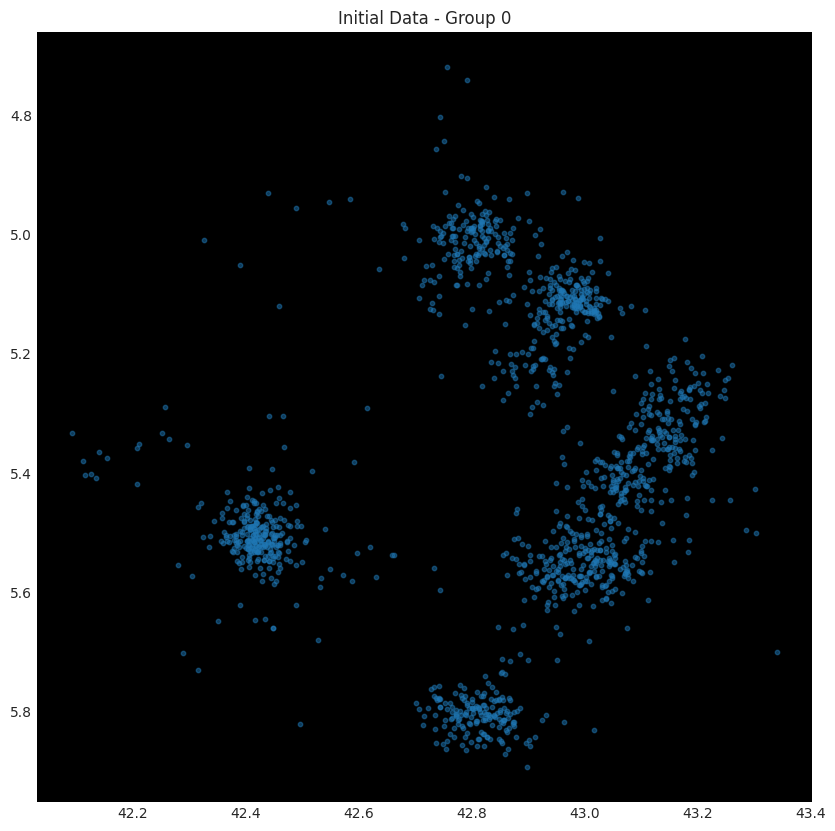

K-Means labels:
 [3 3 3 ... 1 3 2]


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


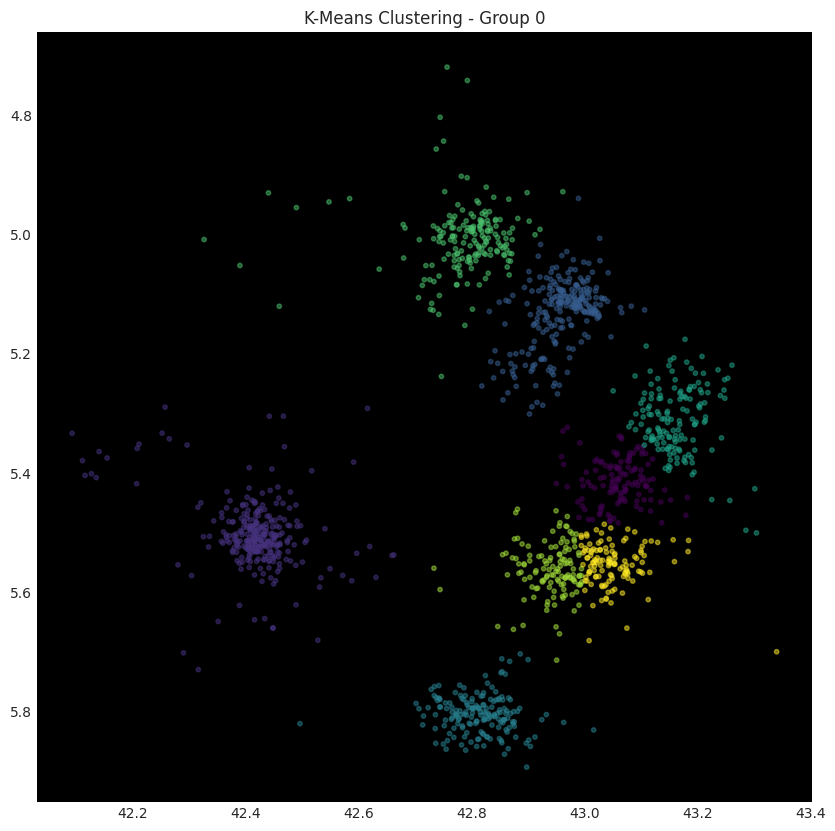

Centers of Mass (COM):
 [(np.float64(43.061126078207664), np.float64(5.414638868467075)), (np.float64(42.41667791915266), np.float64(5.502856372153922)), (np.float64(42.959169372310484), np.float64(5.132997377132012)), (np.float64(42.81332099300691), np.float64(5.80468942927218)), (np.float64(43.16356452941895), np.float64(5.311498661041259)), (np.float64(42.785526715792145), np.float64(5.008267434088738)), (np.float64(42.94034951925278), np.float64(5.562526639550924)), (np.float64(43.05048635864258), np.float64(5.553535488128662))]


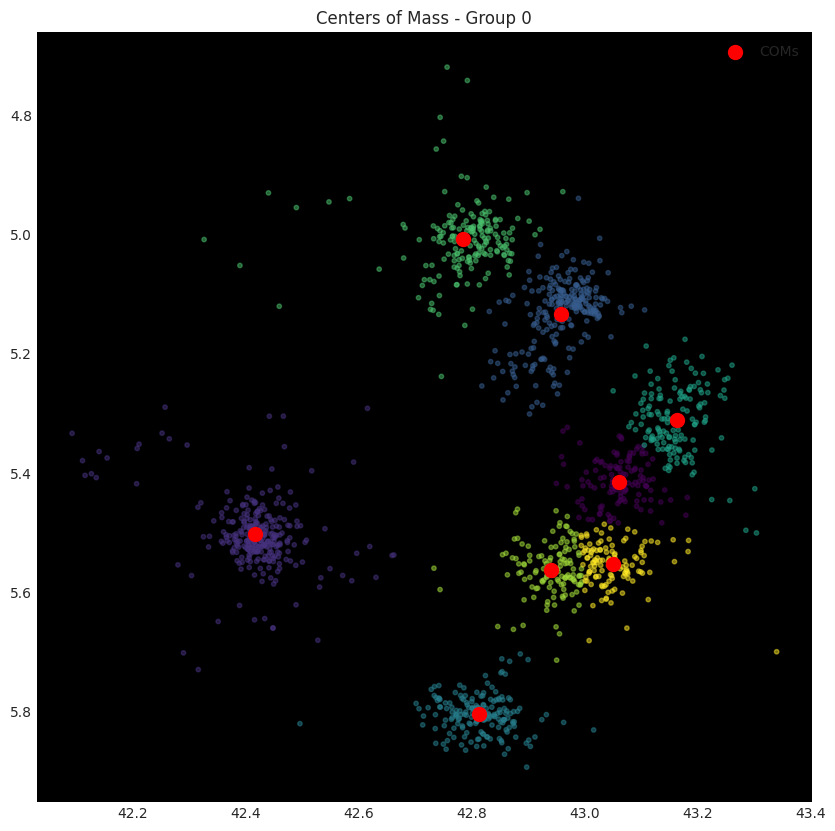

Minimum Bounding Rectangle:
 [[43.21938573  5.32705851]
 [42.78781135  5.00520398]
 [42.41378853  5.50673075]
 [42.84536292  5.82858528]]
Closest side of bounding rectangle:
 3
Closest line start: [42.84536292  5.82858528], end: [43.21938573  5.32705851]
Initial calculated angle: -0.9300089530574447 radians (-53.28558791957188 degrees)
Final rotation angle: 0.9300089530574447 radians (53.28558791957188 degrees)
Rotation angle:
 0.9300089530574447
Rotated Data:
 [[42.8245996   5.90926978]
 [42.82374724  5.80909706]
 [42.84903334  5.80688544]
 [42.87244248  5.8461847 ]
 [42.84444144  5.8177573 ]]
Rotated Centers of Mass (COM):
 [[43.30618183  5.75407823]
 [42.85019607  5.29021107]
 [43.47100032  5.50397432]
 [42.84536292  5.78861409]
 [43.45010208  5.7745355 ]
 [43.46717877  5.29021107]
 [43.11542779  5.74567196]
 [43.18847808  5.82858528]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.071601606647238 radians (233.28558791957187 degrees)


/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


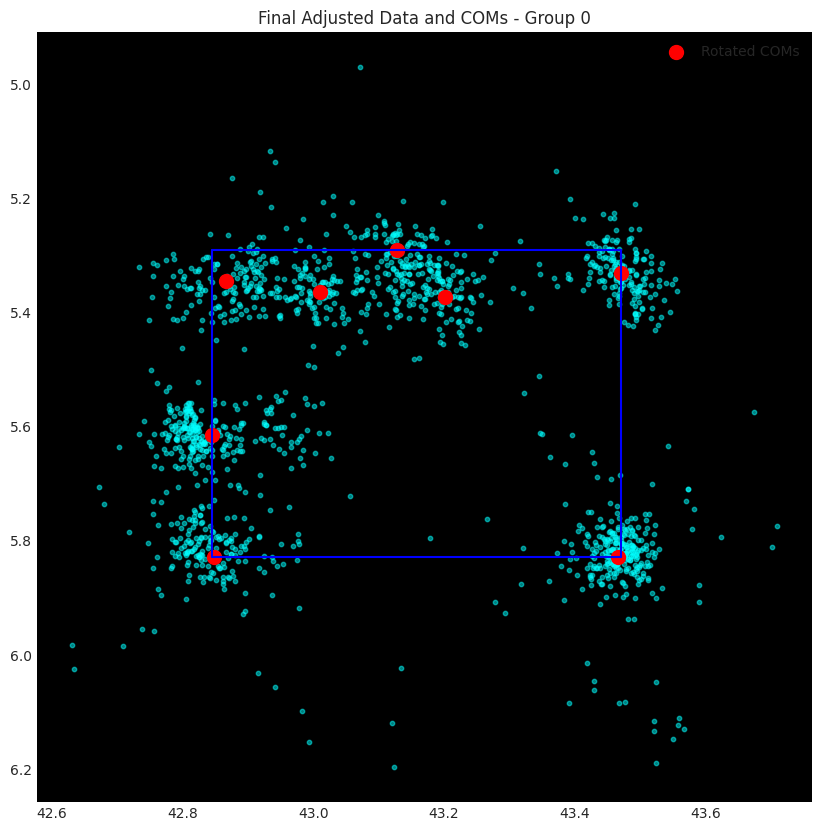

Second Highest COM:
 [42.84536292  5.61482203]
Right Most COM:
 [43.47100032  5.33018227]
Second Right Most COM:
 [43.46616717  5.82858528]
Robot COM:
 [43.20093545  5.3731244 ]


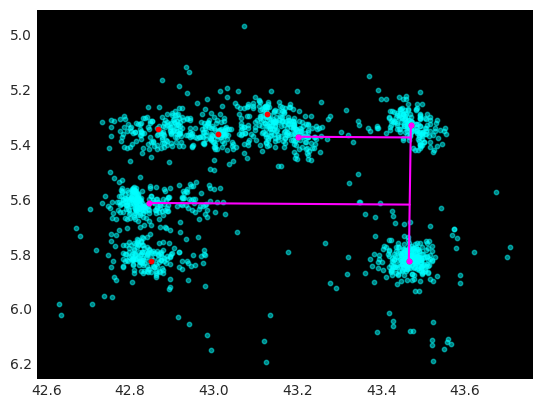

Ratio:
 0.432907903695088

Processing Group 1
Data collected:
            x         y
0  74.181908  2.675268
1  74.218697  2.590031
2  74.369797  3.188938
3  74.364662  3.175110
4  74.386177  3.169834


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


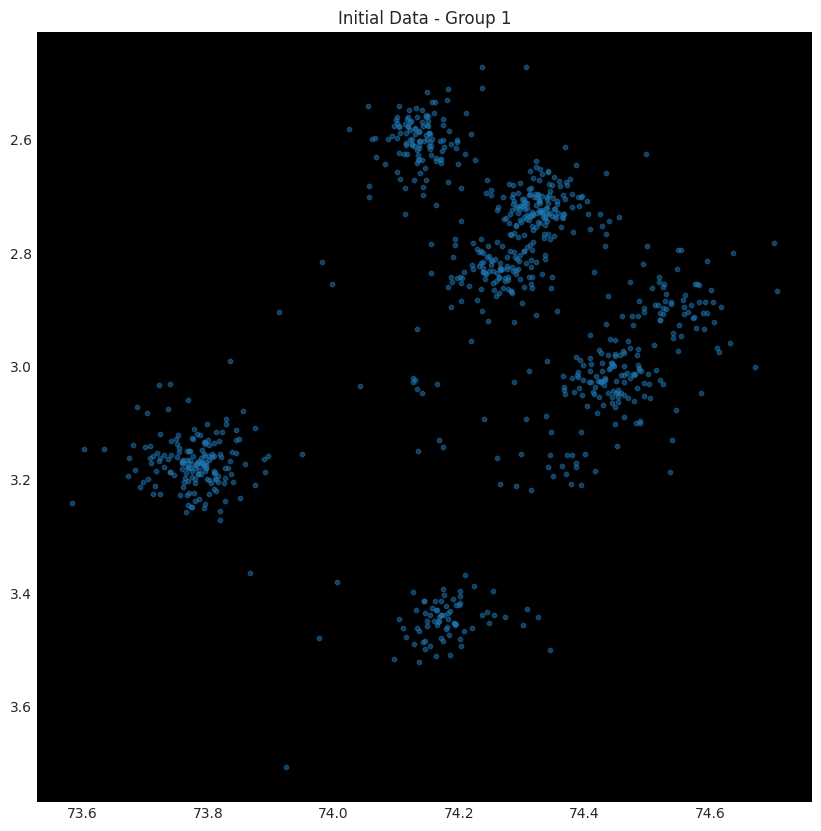

K-Means labels:
 [0 0 1 1 1 1 1 1 1 1 1 7 1 3 3 6 5 5 7 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 6 6 7 7 7 3 3 3 4 4 4 7 7 7 7 7 7 7 4 4 3 3 3 3 3 3 3 0 0 2 2 0 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 5 5 5 5 7 7 5 5 7 7 2 2 2 2 2 2 2 2 6 6 6 5 6 4 4 4 4 7 7 7 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 4 4 4 4 4 4 4 4 7 7 7 7 4
 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 2 2 2 2 2 2
 2 2 0 0 0 0 0 0 0 7 7 7 7 7 7 7 0 0 0 0 2 2 2 5 2 6 7 4 4 4 4 4 4 4 4 0 0
 6 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 2 2 4 2 2 4 0 0 6 6 6 6 6 6 2 6 6 6 6 6 6
 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 1 1 1 1 3 6 0 0 0 7 7 7
 7 1 7 7 7 7 0 2 6 6 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 1 2 0 0
 0 0 0 3 3 3 3 3 3 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 6 2 2 6 0 6 5 3 3
 3 3 3 3 3 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 7 7 1 1 1 2 6 6 0 0 0 0 0 1 3 3 3 3 3 2 2 6 6 6 6 6 6 6 6 6 6
 0 0 2 2

/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


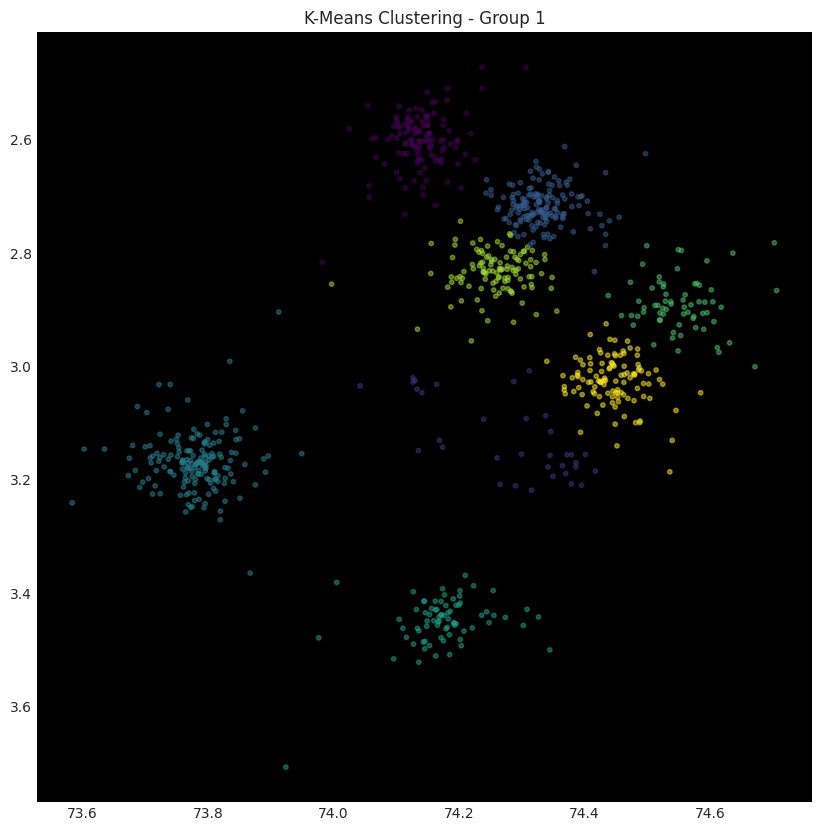

Centers of Mass (COM):
 [(np.float64(74.13930593443311), np.float64(2.602285968370674)), (np.float64(74.27897172815659), np.float64(3.127372938043931)), (np.float64(74.33297290677339), np.float64(2.717069082010805)), (np.float64(73.77946074708493), np.float64(3.168646534046013)), (np.float64(74.17461903889973), np.float64(3.4499339803059894)), (np.float64(74.55210321599787), np.float64(2.89046692125725)), (np.float64(74.25769353545873), np.float64(2.8338319559012892)), (np.float64(74.44544079981813), np.float64(3.026104297112981))]


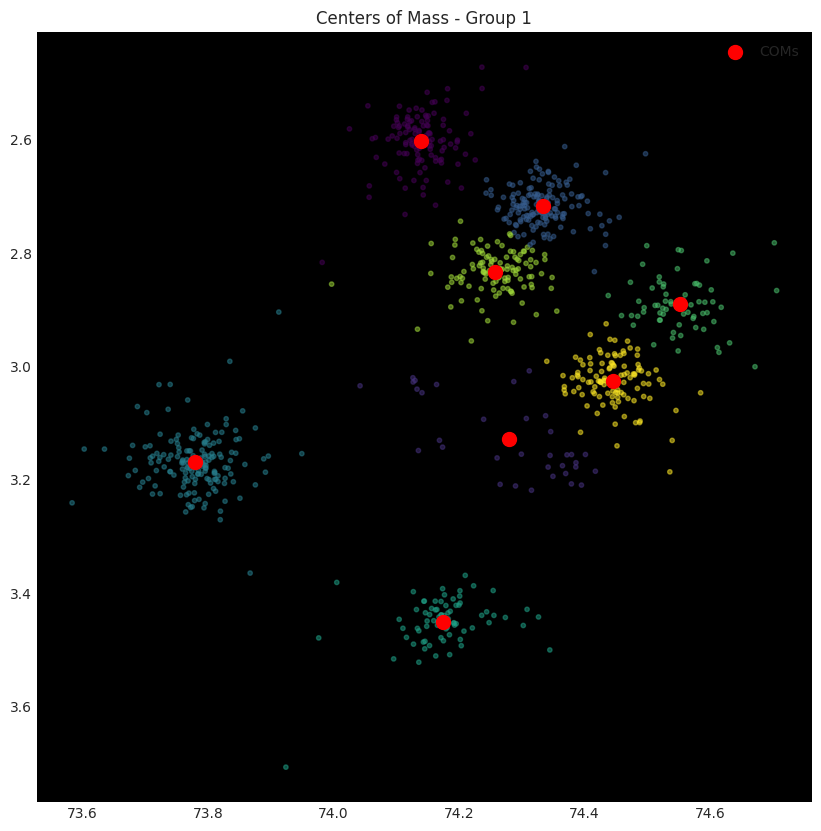

Minimum Bounding Rectangle:
 [[74.56394754  2.87291252]
 [74.14667238  2.5913682 ]
 [73.75734388  3.16838966]
 [74.17461904  3.44993398]]
Closest side of bounding rectangle:
 3
Closest line start: [74.17461904  3.44993398], end: [74.56394754  2.87291252]
Initial calculated angle: -0.977238350767569 radians (-55.99163307730684 degrees)
Final rotation angle: 0.977238350767569 radians (55.99163307730684 degrees)
Rotation angle:
 0.977238350767569
Rotated Data:
 [[74.82085966  3.02269439]
 [74.91209416  3.0055164 ]
 [74.5001389   3.46574895]
 [74.50872969  3.45375852]
 [74.52513721  3.46864223]]
Rotated Centers of Mass (COM):
 [[74.85753075  2.94655961]
 [74.50037384  3.35602486]
 [74.87070125  3.17130078]
 [74.18677638  2.96503718]
 [74.17461904  3.44993398]
 [74.84952473  3.44993398]
 [74.73180518  3.17420461]
 [74.67742955  3.43737942]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.118831004357363 radians (235.99163307730686 degrees)


/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


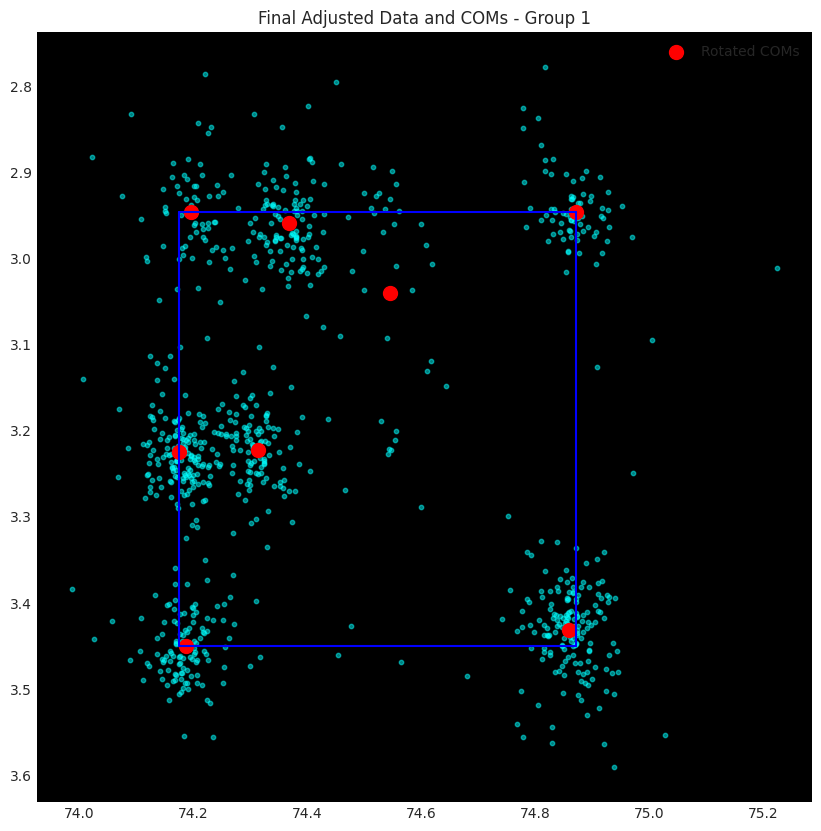

Second Highest COM:
 [74.17461904  3.2251928 ]
Right Most COM:
 [74.87070125  2.94655961]
Second Right Most COM:
 [74.85854391  3.4314564 ]
Robot COM:
 [74.31351512  3.22228898]


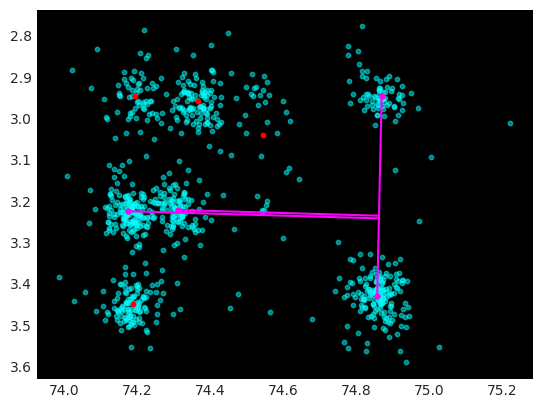

Ratio:
 0.7985430066741575

Processing Group 2
Data collected:
            x          y
0  80.229553  11.981121
1  80.168312  11.962978
2  80.124626  11.972430
3  80.120476  11.994550
4  80.130730  11.978308


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


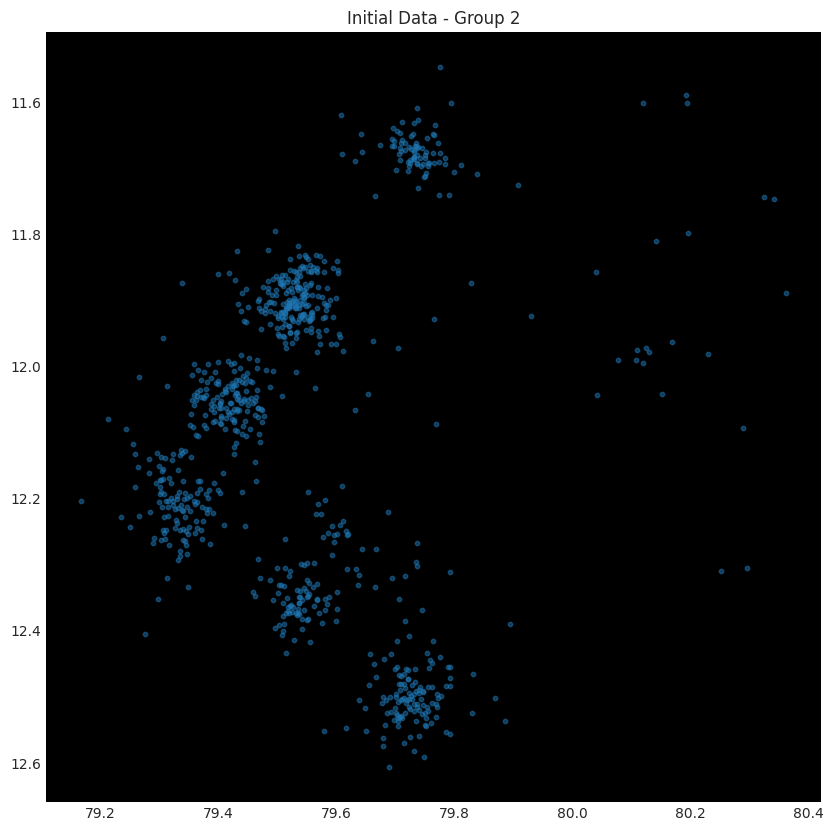

/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


K-Means labels:
 [3 3 3 3 3 1 1 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 7 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 0 0 0 0 2 2
 2 2 2 2 2 2 2 2 2 6 2 7 6 1 1 1 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 1 1 1 4 4 4 4 4 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 0 0 0 6 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 7 7 2 5 5
 5 5 5 1 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 6 0 0 0 0 0 0 0 4 4 4 4 1 2 2 2 2 2 0 4 4 5 5 5 5 5 5 5 5 4 4 0 0 4
 2 2 2 2 2 2 4 6 6 5 5 4 4 4 4 0 0 0 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 0 0 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 5 5 4 6
 5 6 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 7 7 5 2 2 2 6 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 1 1 1 1 1 1 1 1 1 1 1 6 6 6 0 0 1 0
 0 0 6 6 6 6 6 6 6 6 6 5 5 4 4 6 6 6 6 4 7 3 4 4 4 6 6 6 6 0 0 0 0 6 0 0 5
 5 5 5 5

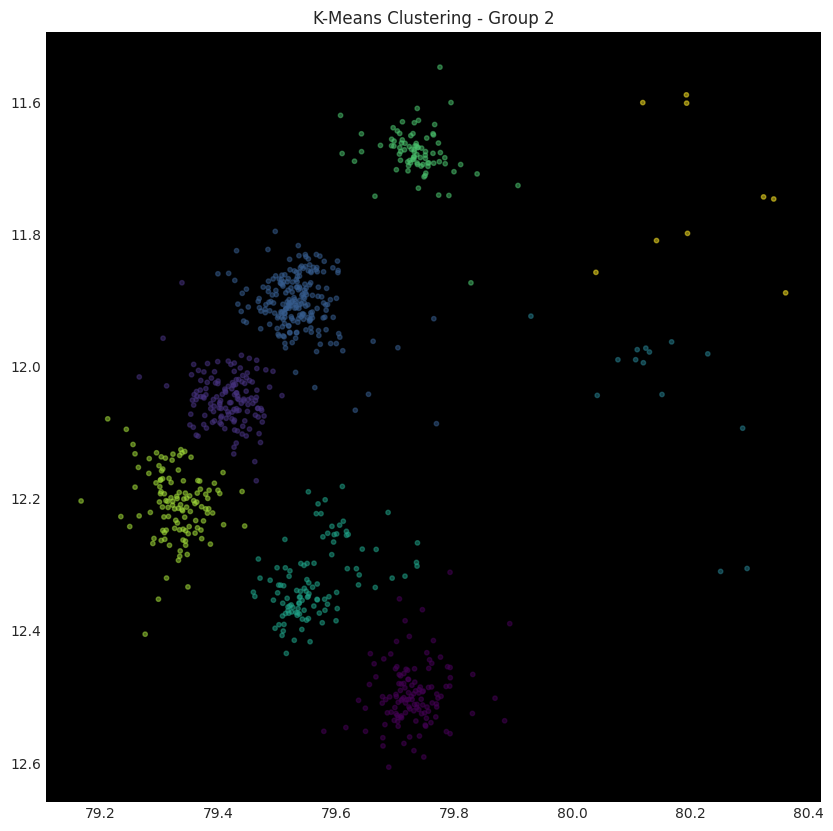

Centers of Mass (COM):
 [(np.float64(79.72952196674962), np.float64(12.496960755317442)), (np.float64(79.41719585445756), np.float64(12.050053156859486)), (np.float64(79.5342530664408), np.float64(11.903688759173987)), (np.float64(80.14492579868862), np.float64(12.040319034031459)), (np.float64(79.56182626029042), np.float64(12.327570995437764)), (np.float64(79.73547944568452), np.float64(11.677294004531134)), (np.float64(79.33030194194377), np.float64(12.20881382757876)), (np.float64(80.21236504448785), np.float64(11.737446784973145))]


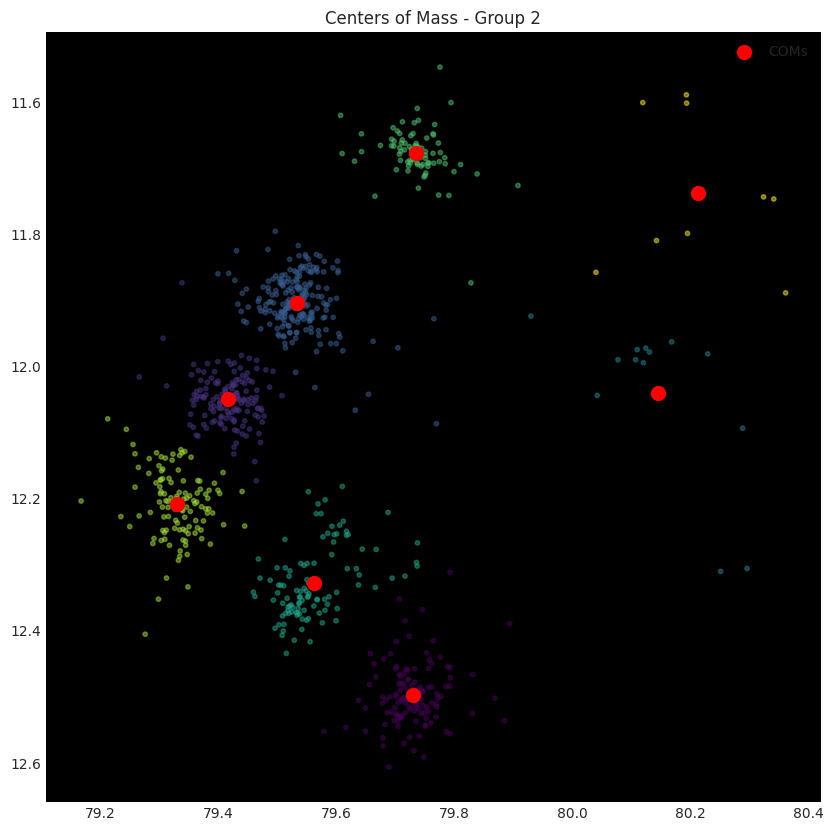

Minimum Bounding Rectangle:
 [[80.32508043 11.83763157]
 [79.91608249 11.47410205]
 [79.29273076 12.17541945]
 [79.70172871 12.53894897]]
Closest side of bounding rectangle:
 1
Closest line start: [79.91608249 11.47410205], end: [79.29273076 12.17541945]
Initial calculated angle: 2.2974055959337085 radians (131.63164447673927 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.438998249523502 radians (311.63164447673927 degrees)
Final rotation angle: -5.438998249523502 radians (-311.63164447673927 degrees)
Rotation angle:
 -5.438998249523502
Rotated Data:
 [[79.74537149 12.04523245]
 [79.71824702 11.987406  ]
 [79.68216013 11.96103302]
 [79.66287004 11.97262575]
 [79.68182191 11.96949963]]
Rotated Centers of Mass (COM):
 [[79.02762643 12.01418593]
 [79.1541687  11.48384542]
 [79.34133172 11.47410205]
 [79.64490376 12.0213068 ]
 [79.04282682 11.77631267]
 [79.6442288  11.47410205]
 [78.97777898 11.52436912]
 [79.91608249 11.87050311]]
Final rotation angle after adjustment: -5.43

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


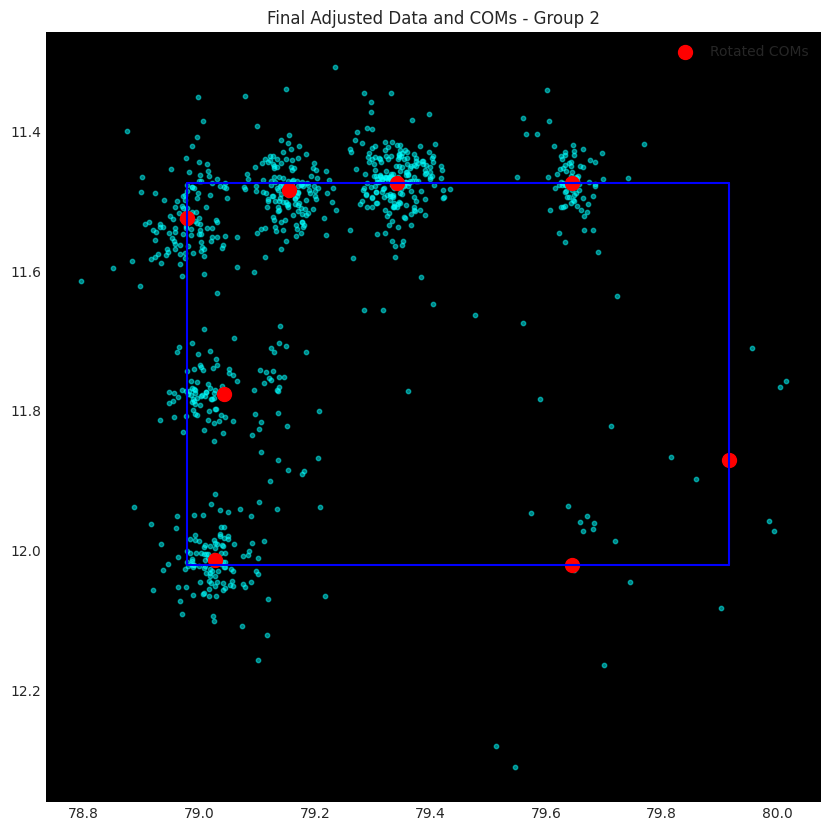

Second Highest COM:
 [79.04282682 11.77631267]
Right Most COM:
 [79.91608249 11.87050311]
Second Right Most COM:
 [79.64490376 12.0213068 ]
Robot COM:
 [79.34133172 11.47410205]


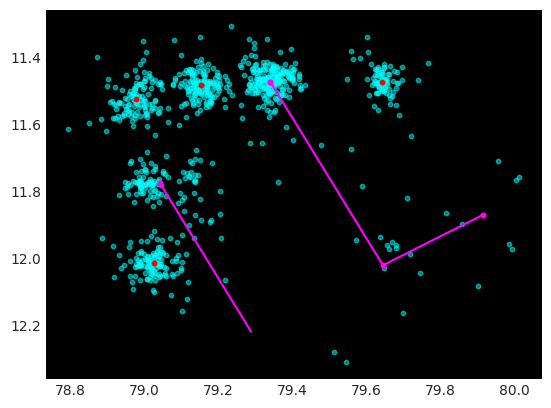

Ratio:
 1.234922341201315

Processing Group 3
Data collected:
            x         y
0  96.276115  5.262790
1  96.280777  5.182926
2  96.253075  5.196754
3  96.216118  5.205290
4  96.236908  5.174649


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


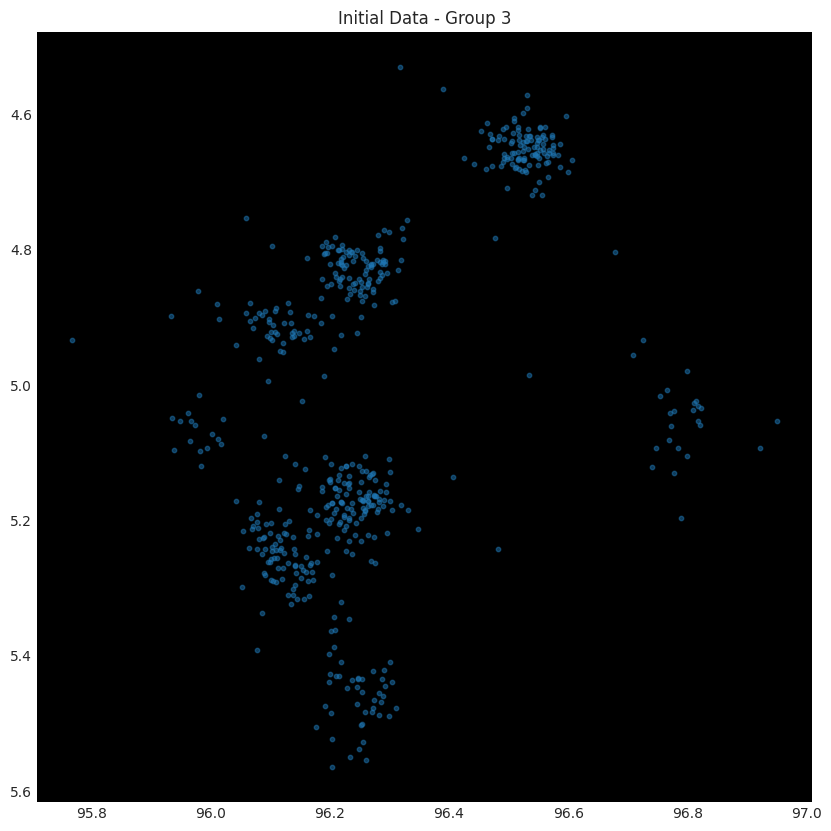

K-Means labels:
 [6 6 6 6 6 0 0 0 0 0 0 0 0 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 2
 2 2 2 2 2 1 1 1 5 5 5 2 2 2 2 3 3 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 5 5 5 5 5 5 5 5 6 6 2 2 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0
 2 2 0 0 0 0 0 2 2 2 2 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 3 3
 3 3 3 6 5 5 5 7 7 7 7 6 7 6 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6
 6 6 5 6 5 5 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 3 3
 3 3 3 1 1 5 6 6 3 5 5 5 6 6 1 1 1 1 5 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 6
 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 7 7 7 3 3 3 3 3 5 4 4 4 4 4 4 4
 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 6 6 6 6 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 5 5
 6 5 5 6 6 6 6 7 7 7 5 5 5 6 6 7 6 6 6 4 0 0 0 0 0 0 0 6 4 4 0 0 6 6 1 6 6
 6 6 4 4 4 6 6 6 6 4 4 4 7 6 6 6 6 6 6 6 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 6
 6 4 5 5

/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


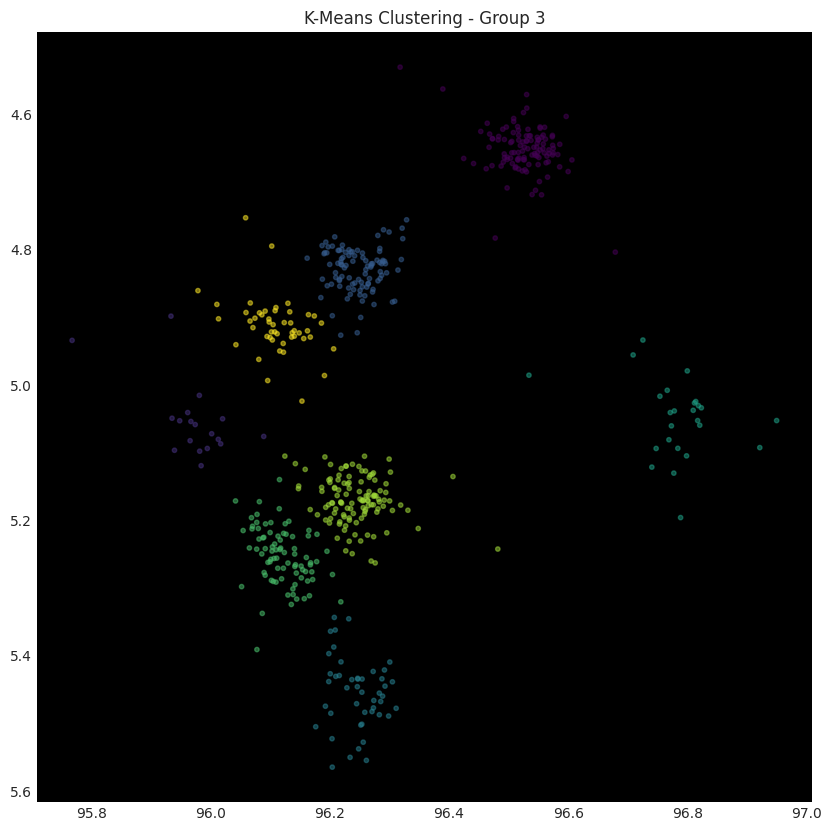

Centers of Mass (COM):
 [(np.float64(96.52659242343059), np.float64(4.651792268837448)), (np.float64(95.97059546576605), np.float64(5.053029855092366)), (np.float64(96.2470948961046), np.float64(4.829189396867848)), (np.float64(96.24598710433297), np.float64(5.454964492631995)), (np.float64(96.78432647705078), np.float64(5.049751472473145)), (np.float64(96.12027545091583), np.float64(5.252703178219679)), (np.float64(96.24395824300832), np.float64(5.169995365471675)), (np.float64(96.10949961344402), np.float64(4.912443409363429))]


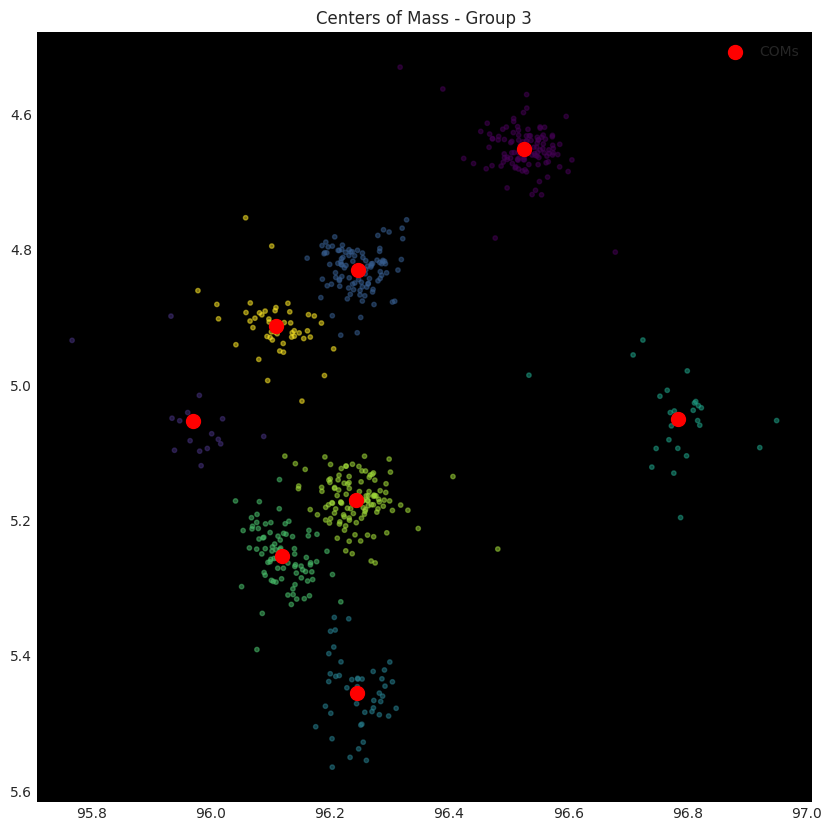

Minimum Bounding Rectangle:
 [[96.81144371  5.06753329]
 [96.51487669  4.63469313]
 [95.94942008  5.02212434]
 [96.2459871   5.45496449]]
Closest side of bounding rectangle:
 1
Closest line start: [96.51487669  4.63469313], end: [95.94942008  5.02212434]
Initial calculated angle: 2.540892449851184 radians (145.582413573129 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.6824851034409765 radians (325.582413573129 degrees)
Final rotation angle: -5.6824851034409765 radians (-325.582413573129 degrees)
Rotation angle:
 -5.6824851034409765
Rotated Data:
 [[95.96289978  5.01788286]
 [96.01188632  4.95463424]
 [95.98121726  4.95038421]
 [95.94590549  4.93653706]
 [95.9803753   4.9230106 ]]
Rotated Centers of Mass (COM):
 [[96.51487669  4.65542086]
 [95.82942493  4.67215709]
 [96.18403954  4.6437852 ]
 [95.82942493  5.15938599]
 [96.50255724  5.12938985]
 [95.84004254  4.92147776]
 [95.98882156  4.92315679]
 [96.02347483  4.63469313]]
Final rotation angle after adjustment: -5.682485

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


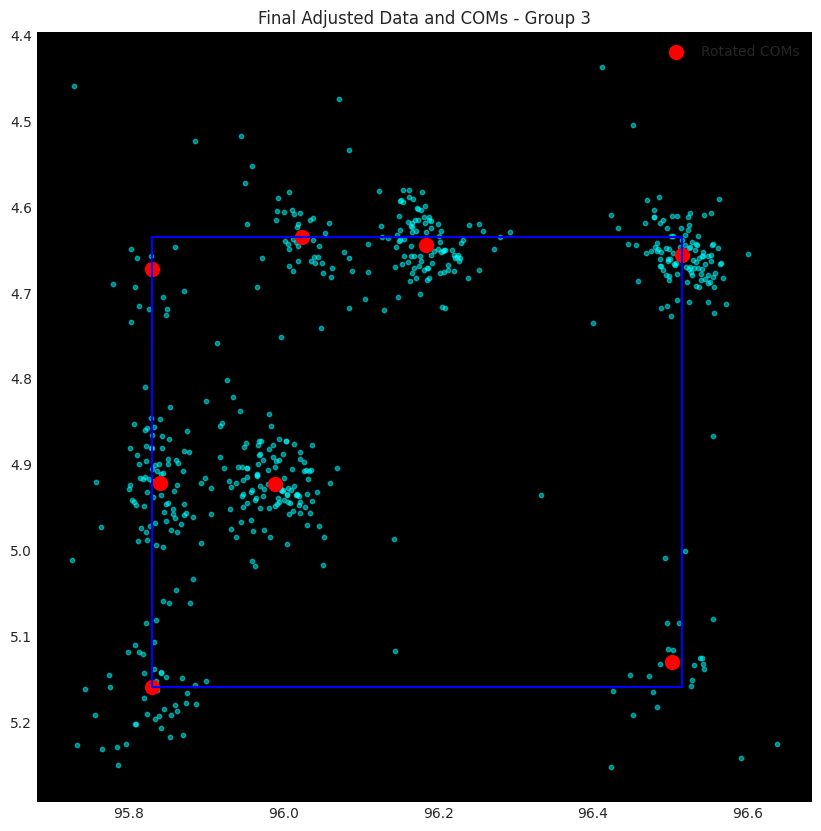

Second Highest COM:
 [95.84004254  4.92147776]
Right Most COM:
 [96.51487669  4.65542086]
Second Right Most COM:
 [96.50255724  5.12938985]
Robot COM:
 [95.98882156  4.92315679]


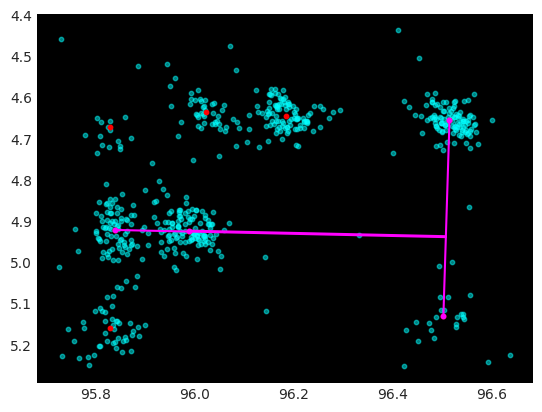

Ratio:
 0.7771844927893748

Processing Group 4
Data collected:
             x          y
0  154.937286  12.149701
1  154.065964  12.067630
2  154.442245  12.426337
3  154.473663  12.418509
4  154.446823  12.387403


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


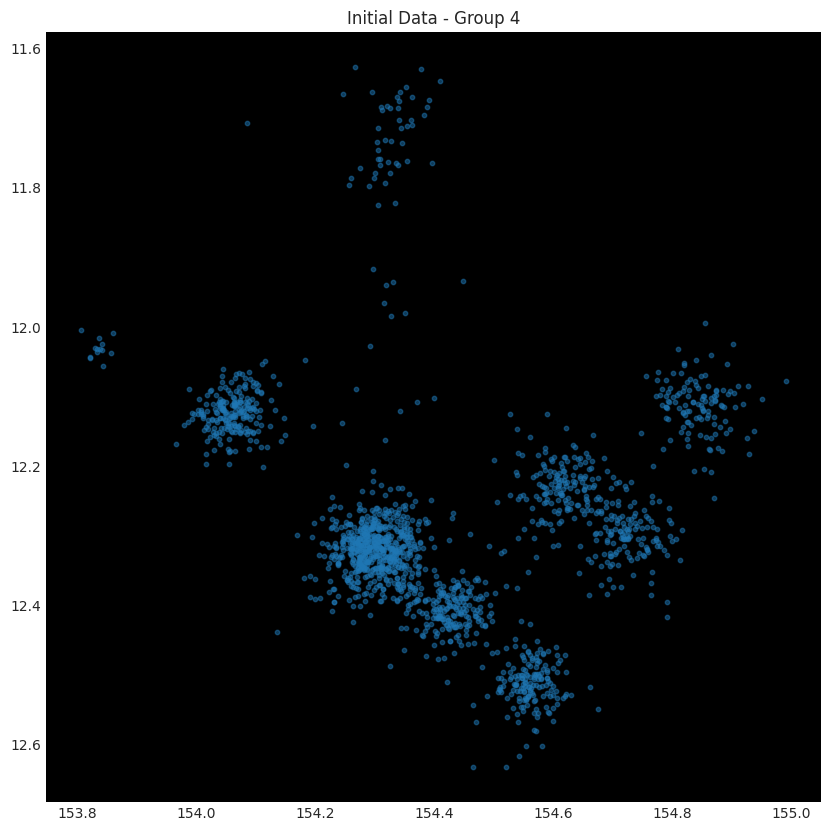

K-Means labels:
 [0 2 6 ... 3 3 3]


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


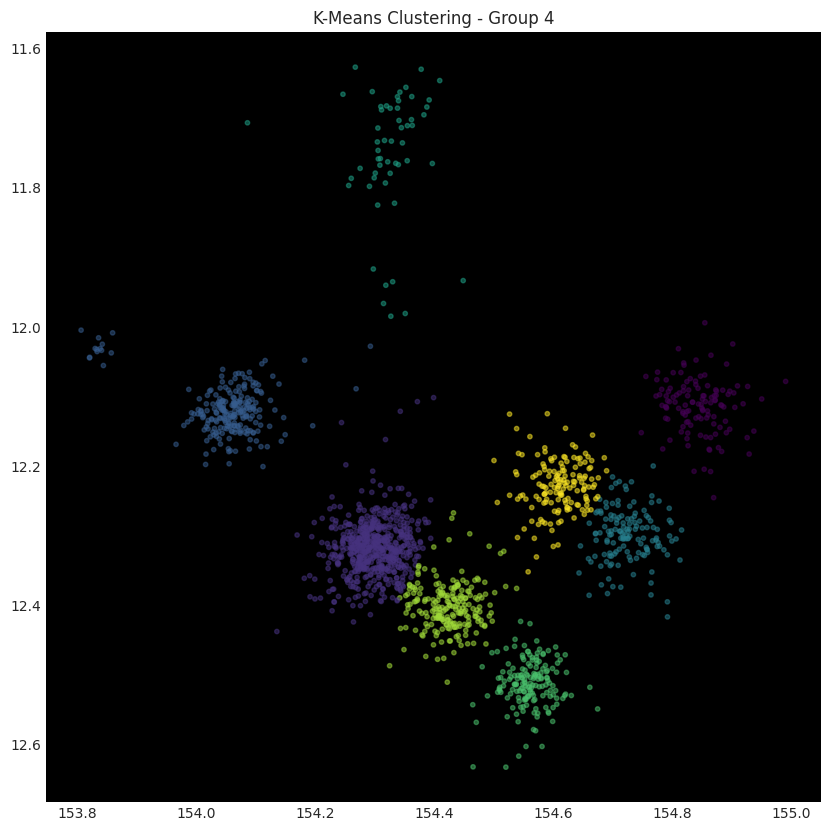

Centers of Mass (COM):
 [(np.float64(154.84418657791517), np.float64(12.113616872424922)), (np.float64(154.29785808378548), np.float64(12.317404563916545)), (np.float64(154.05118603727), np.float64(12.117638014095686)), (np.float64(154.72505798339844), np.float64(12.299547467912946)), (np.float64(154.32502330433238), np.float64(11.752556471391157)), (np.float64(154.56031336103166), np.float64(12.51306314695449)), (np.float64(154.42449521151457), np.float64(12.401920357617465)), (np.float64(154.6097392032021), np.float64(12.228787083374826))]


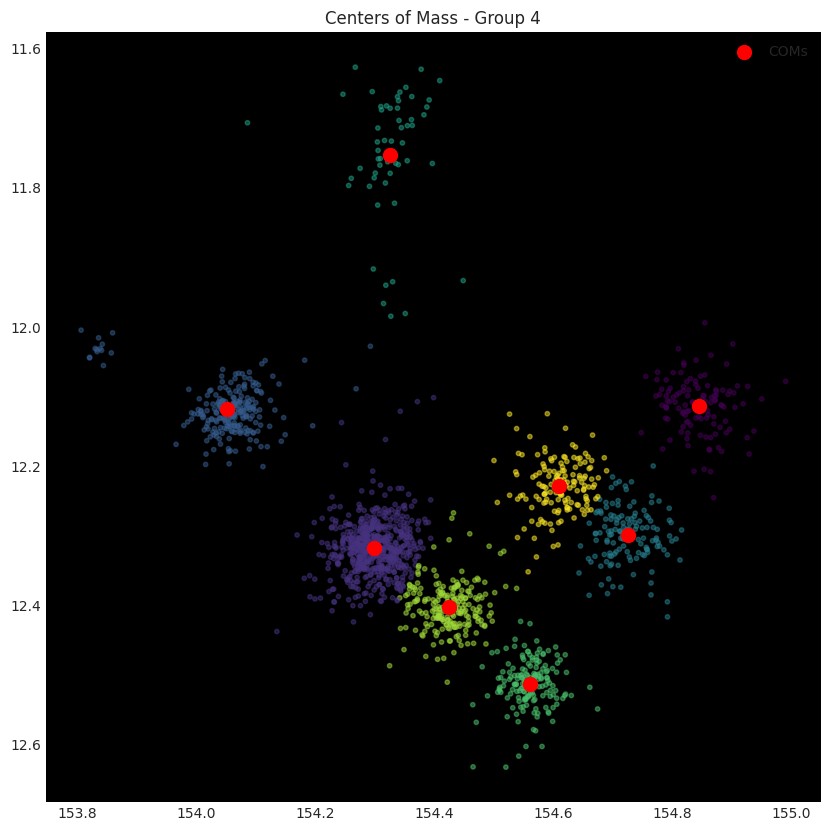

Minimum Bounding Rectangle:
 [[154.85670867  12.12295201]
 [154.33639433  11.73506128]
 [154.04357937  12.12784155]
 [154.56389371  12.51573228]]
Closest side of bounding rectangle:
 2
Closest line start: [154.04357937  12.12784155], end: [154.56389371  12.51573228]
Initial calculated angle: 0.6406104101801188 radians (36.704272815465316 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.782203063769912 radians (216.70427281546532 degrees)
Final rotation angle: -3.782203063769912 radians (-216.70427281546532 degrees)
Rotation angle:
 -3.782203063769912
Rotated Data:
 [[153.31400156  12.64447128]
 [154.06162077  12.18949398]
 [153.54554998  12.12680501]
 [153.52504042  12.15185951]
 [153.56515064  12.16075616]]
Rotated Centers of Mass (COM):
 [[153.41020957  12.61775679]
 [153.72641727  12.12784155]
 [154.04357937  12.14056844]
 [153.39459075  12.39748909]
 [154.04223926  12.59693406]
 [153.39905653  12.12784155]
 [153.57437453  12.13577172]
 [153.52933782  12.38529559]]
Final 

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


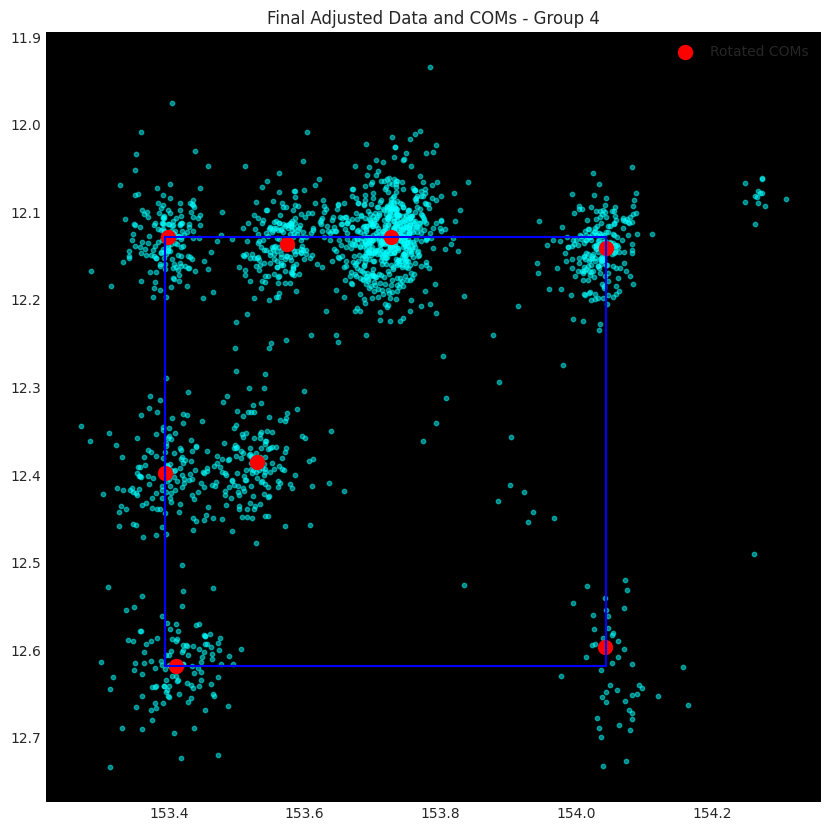

Second Highest COM:
 [153.39459075  12.39748909]
Right Most COM:
 [154.04357937  12.14056844]
Second Right Most COM:
 [154.04223926  12.59693406]
Robot COM:
 [153.52933782  12.38529559]


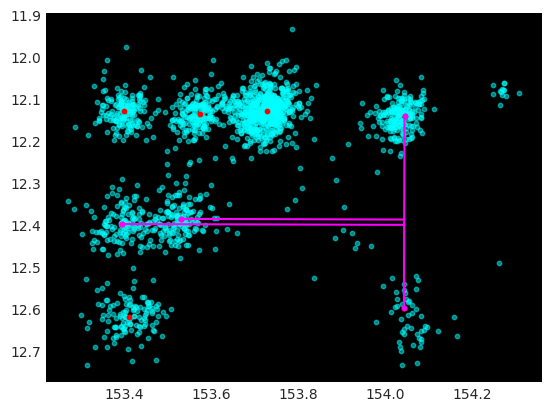

Ratio:
 0.7921873542907827

Processing Group 5
Data collected:
             x          y
0  190.320480  16.102219
1  190.276398  16.173414
2  190.258575  16.114859
3  190.139954  16.050495
4  190.059372  16.388666


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


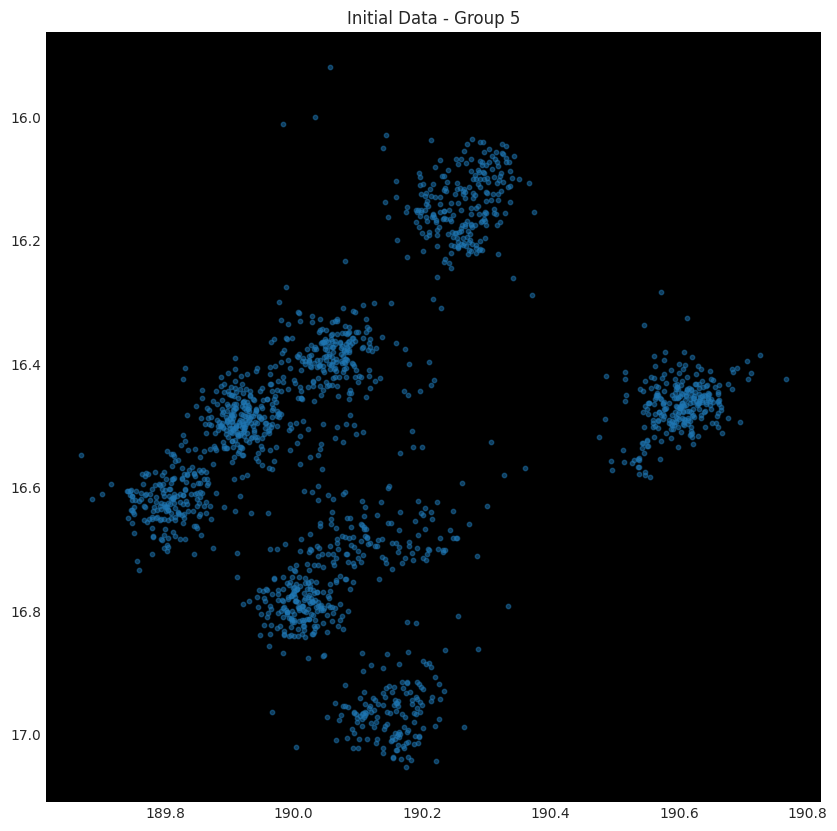

/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


K-Means labels:
 [4 4 4 ... 3 3 3]


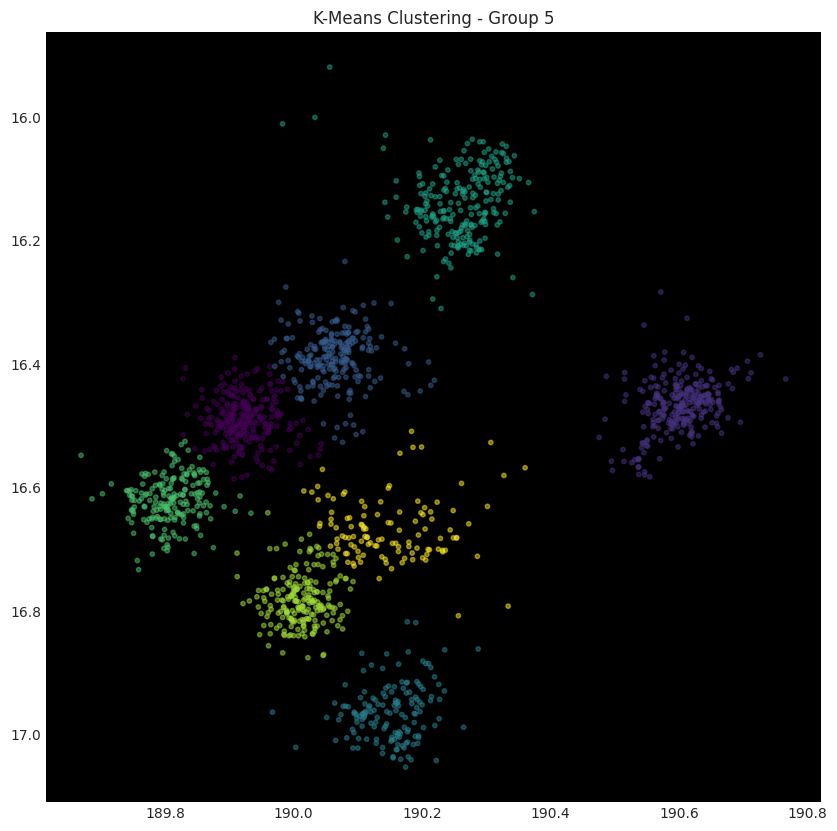

Centers of Mass (COM):
 [(np.float64(189.92427917709924), np.float64(16.489982612150953)), (np.float64(190.60105555651356), np.float64(16.46740259645597)), (np.float64(190.0642186505762), np.float64(16.389368635496943)), (np.float64(190.1514623245137), np.float64(16.963087056307184)), (np.float64(190.25993032823817), np.float64(16.14046060783157)), (np.float64(189.808189002835), np.float64(16.620651176997594)), (np.float64(190.01223790701567), np.float64(16.78151156644866)), (np.float64(190.14929564386352), np.float64(16.66652112129407))]


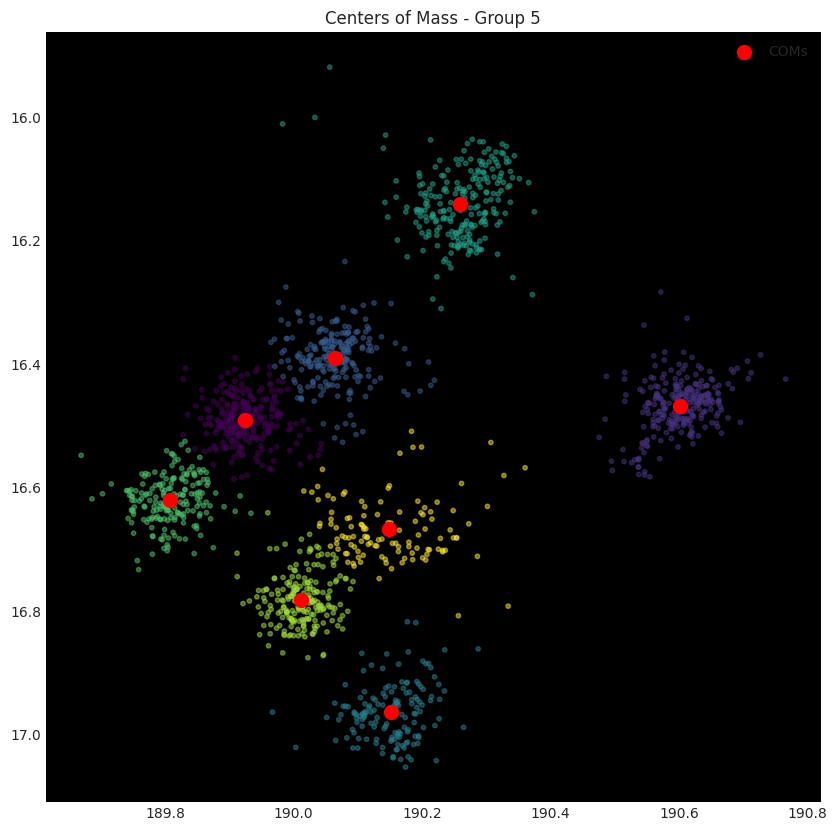

Minimum Bounding Rectangle:
 [[190.61433717  16.48013199]
 [190.25958554  16.14013015]
 [189.79671069  16.62308522]
 [190.15146232  16.96308706]]
Closest side of bounding rectangle:
 1
Closest line start: [190.25958554  16.14013015], end: [189.79671069  16.62308522]
Initial calculated angle: 2.3349674205800315 radians (133.78377849978403 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.476560074169825 radians (313.7837784997841 degrees)
Final rotation angle: -5.476560074169825 radians (-313.7837784997841 degrees)
Rotation angle:
 -5.476560074169825
Rotated Data:
 [[190.32909148  16.15786108]
 [190.24718888  16.17529835]
 [190.27713154  16.12191456]
 [190.24152011  15.99173921]
 [189.94161789  16.16755642]]
Rotated Centers of Mass (COM):
 [[189.77499592  16.14013015]
 [190.25958554  16.61310904]
 [189.94446435  16.1715416 ]
 [189.59063209  16.63150575]
 [190.25958554  16.14060773]
 [189.60033165  16.14673279]
 [189.62538685  16.4053527 ]
 [189.80324048  16.42473602]]
Final ro

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


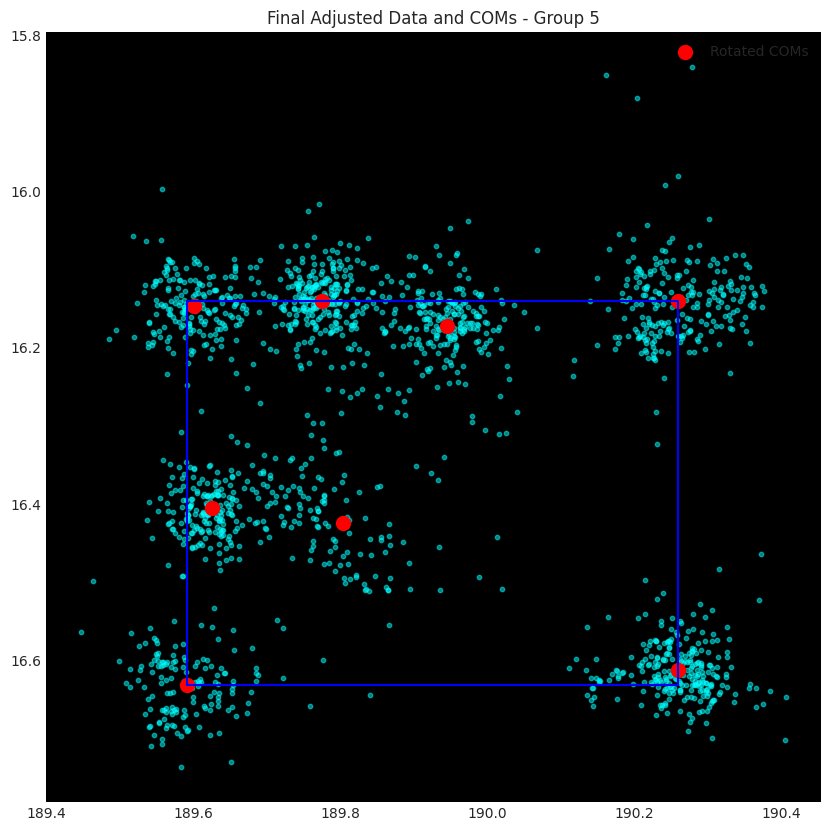

Second Highest COM:
 [189.62538685  16.4053527 ]
Right Most COM:
 [190.25958554  16.14060773]
Second Right Most COM:
 [190.25958554  16.61310904]
Robot COM:
 [189.80324048  16.42473602]


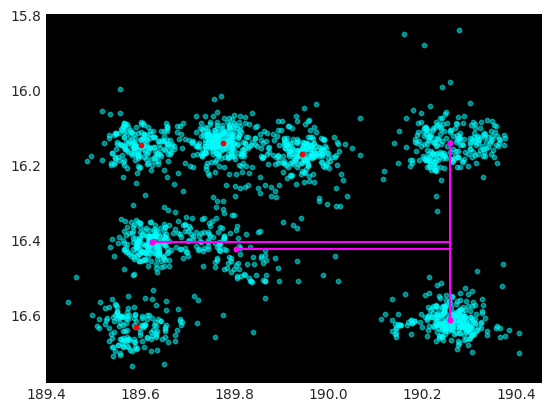

Ratio:
 0.7195616600047895

Processing Group 6
Data collected:
             x         y
0  192.853226  3.511629
1  192.808411  3.494667
2  192.990067  3.477808
3  192.797516  3.549601
4  192.846237  3.472739


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


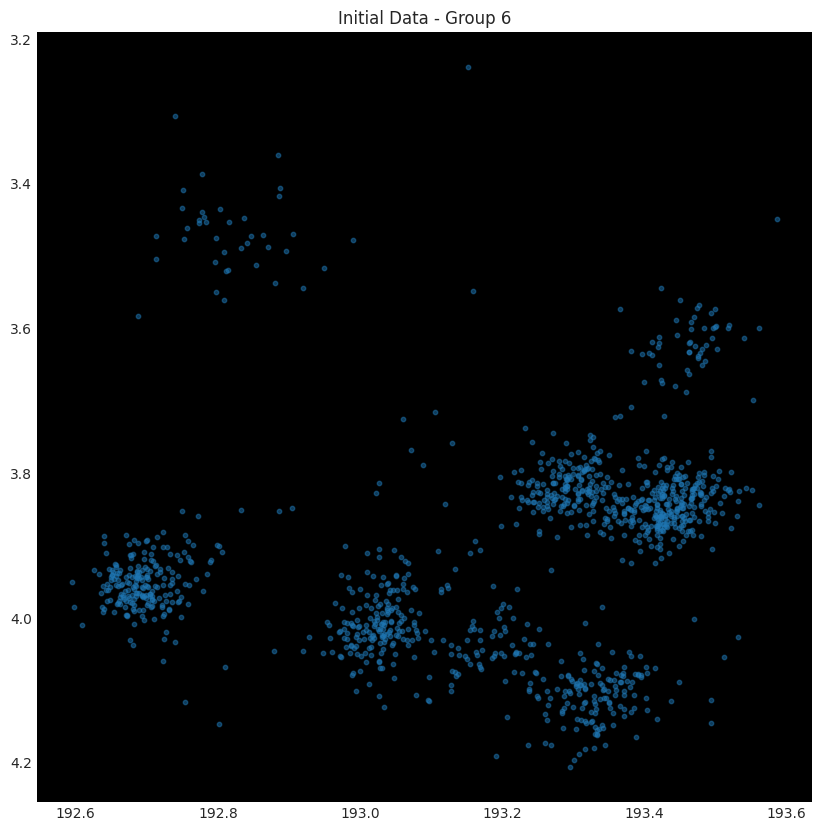

K-Means labels:
 [3 3 3 ... 1 1 4]


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


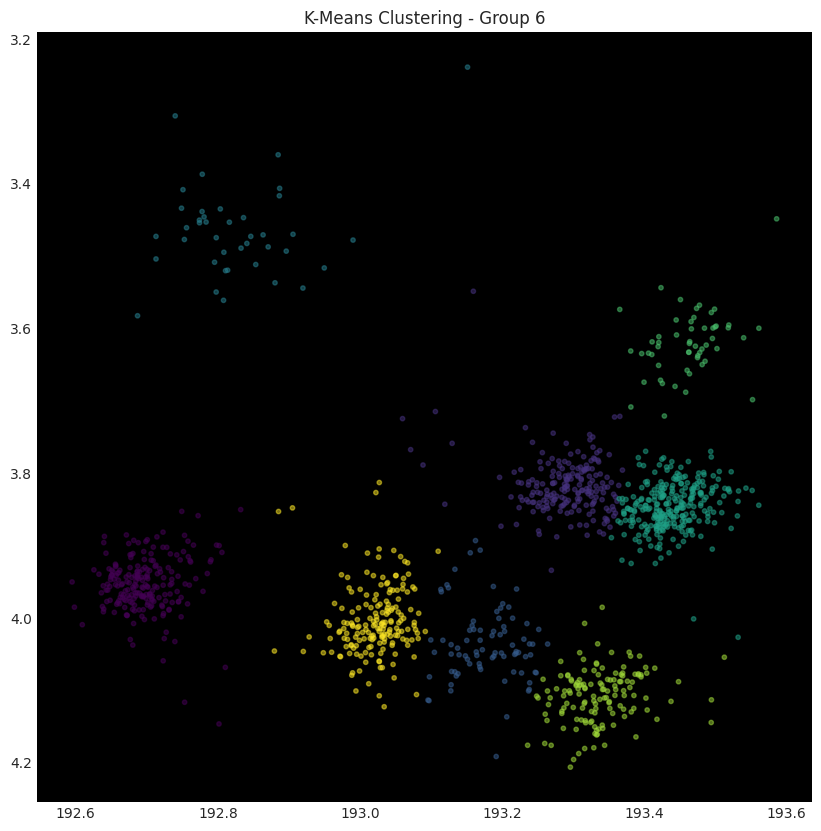

Centers of Mass (COM):
 [(np.float64(192.69750955071248), np.float64(3.9537883241411667)), (np.float64(193.2893615415947), np.float64(3.8175938009616717)), (np.float64(193.17829009633004), np.float64(4.0361552238464355)), (np.float64(192.82681579589843), np.float64(3.46524173617363)), (np.float64(193.43850013925712), np.float64(3.8464720576248443)), (np.float64(193.4624910707827), np.float64(3.620672071421588)), (np.float64(193.33668298515485), np.float64(4.107724654588768)), (np.float64(193.02164210535545), np.float64(4.003581663521614))]


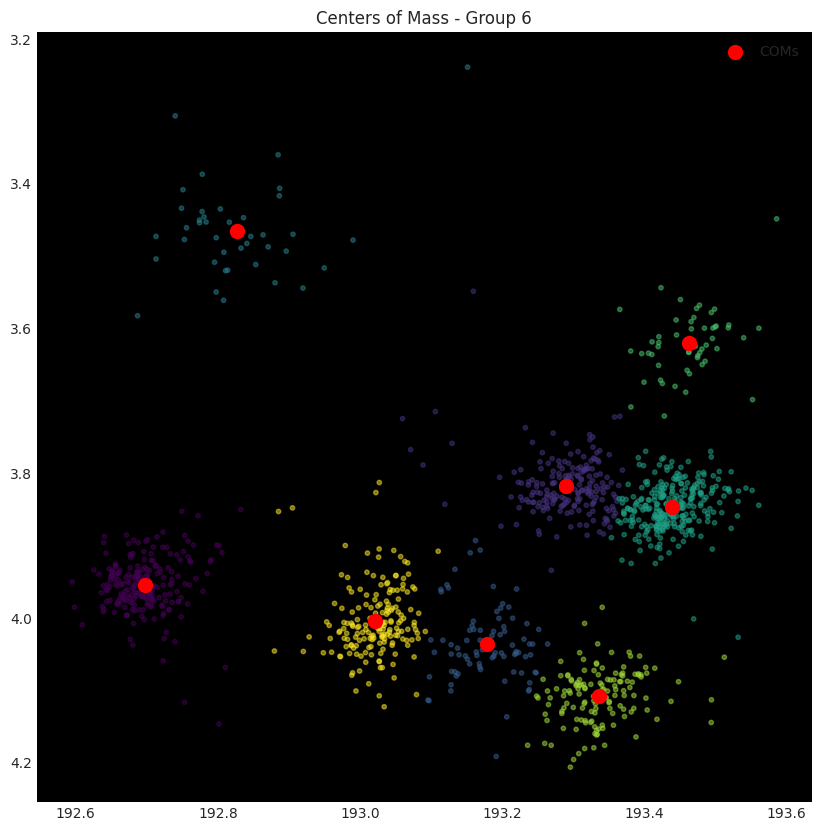

Minimum Bounding Rectangle:
 [[193.49194976   3.62787508]
 [192.81752084   3.46296901]
 [192.69750955   3.95378832]
 [193.37193847   4.1186944 ]]
Closest side of bounding rectangle:
 2
Closest line start: [192.69750955   3.95378832], end: [193.37193847   4.1186944 ]
Initial calculated angle: 0.23980700643578945 radians (13.739929366437305 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.3813996600255827 radians (193.7399293664373 degrees)
Final rotation angle: -3.3813996600255827 radians (-193.7399293664373 degrees)
Rotation angle:
 -3.3813996600255827
Rotated Data:
 [[192.65126885   4.42027936]
 [192.69883028   4.42611199]
 [192.52637686   4.48563417]
 [192.69636563   4.3701623 ]
 [192.6672945    4.45639718]]
Rotated Centers of Mass (COM):
 [[192.69750955   3.95378832]
 [192.15494236   4.2266593 ]
 [192.21092371   3.98797112]
 [192.68794078   4.45906677]
 [192.00321251   4.23403011]
 [192.03353903   4.45906677]
 [192.0400646    3.95607044]
 [192.37082575   3.98240627]]
Fina

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


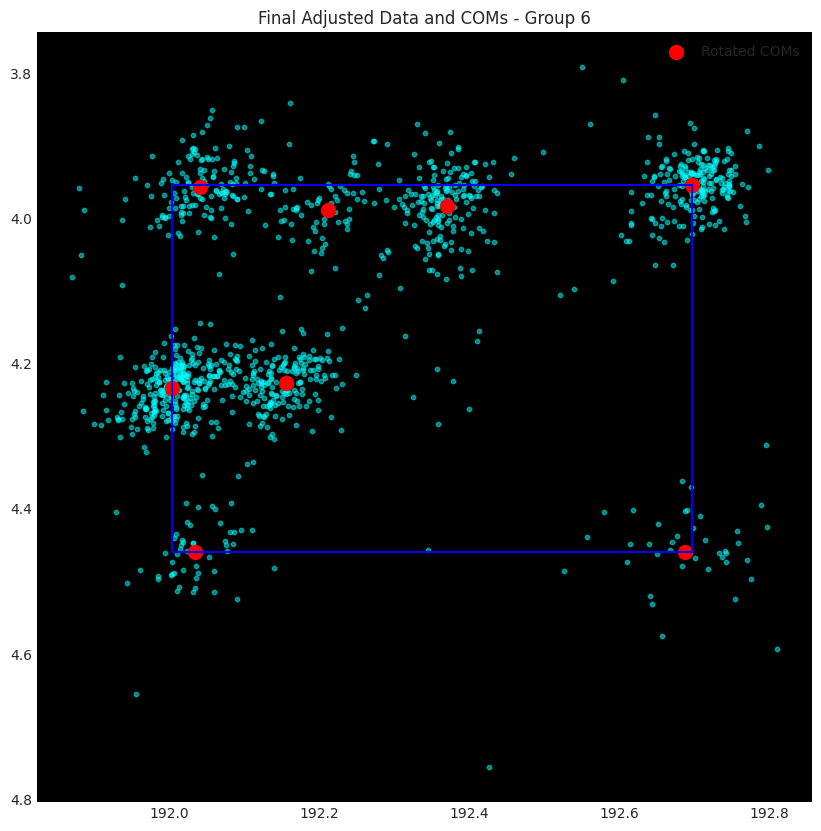

Second Highest COM:
 [192.00321251   4.23403011]
Right Most COM:
 [192.69750955   3.95378832]
Second Right Most COM:
 [192.68794078   4.45906677]
Robot COM:
 [192.15494236   4.2266593 ]


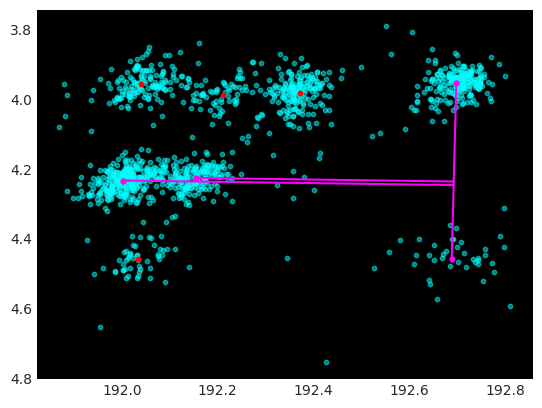

Ratio:
 0.7799818899101107

Processing Group 7
Data collected:
             x          y
0  223.384872  14.570362
1  223.379608  14.605626
2  223.415466  14.562952
3  223.395050  14.599780
4  223.444214  14.630434


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


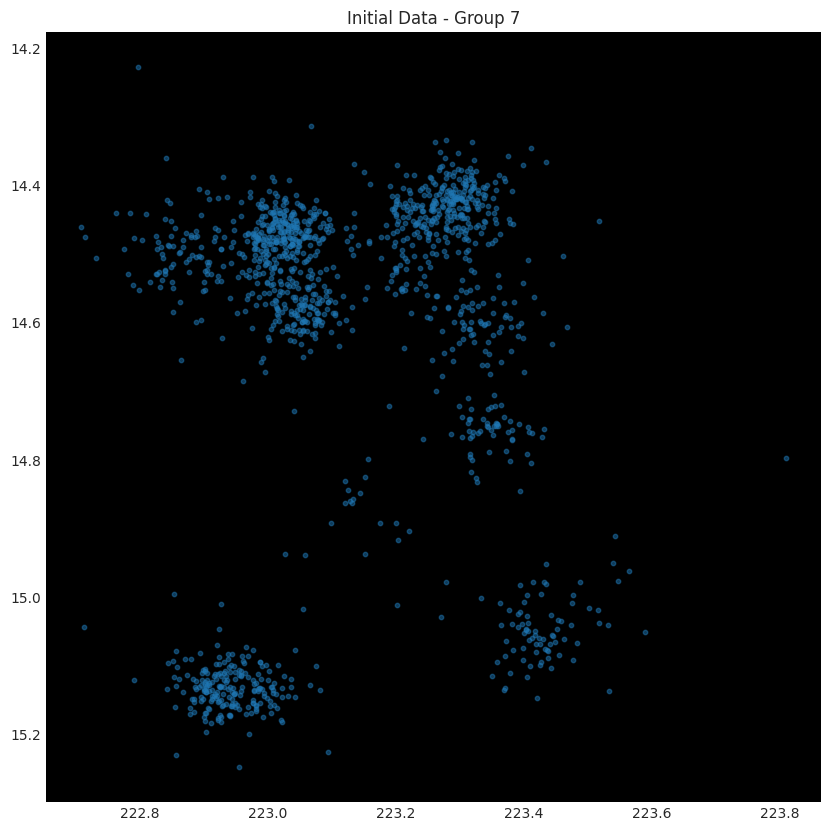

K-Means labels:
 [7 7 7 ... 2 3 5]


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


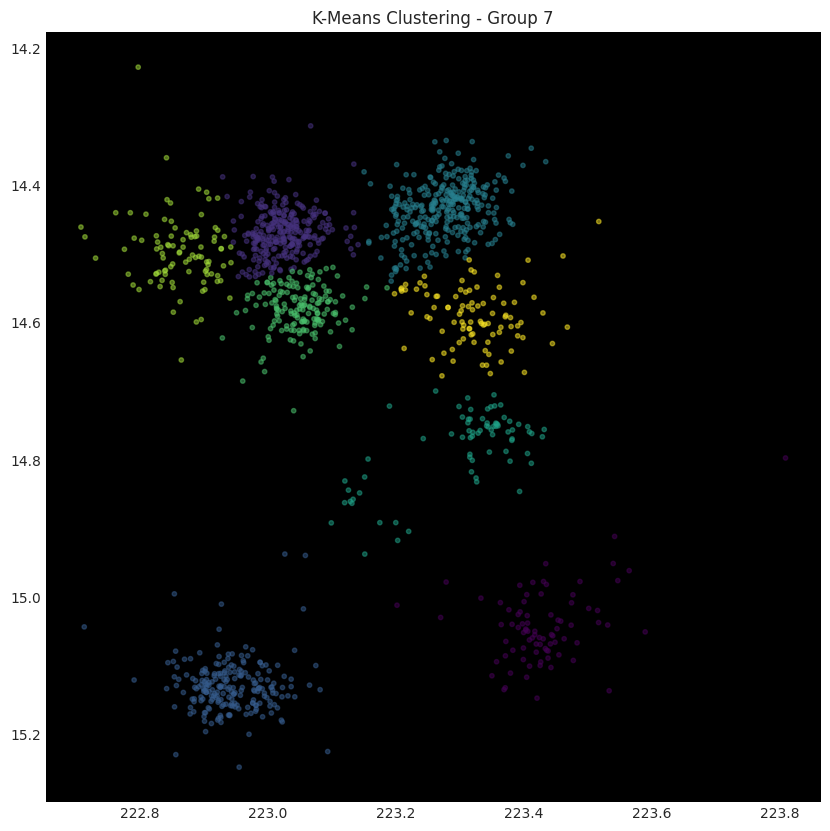

Centers of Mass (COM):
 [(np.float64(223.42969177990426), np.float64(15.043157368171507)), (np.float64(223.02327102551357), np.float64(14.468674906723791)), (np.float64(222.94146528867918), np.float64(15.129941155977338)), (np.float64(223.27476365045206), np.float64(14.434383297598124)), (np.float64(223.30488359605943), np.float64(14.781124321190086)), (np.float64(223.04856458122347), np.float64(14.579886047928422)), (np.float64(222.86249915589678), np.float64(14.496709935208584)), (np.float64(223.32092236457987), np.float64(14.588685634288382))]


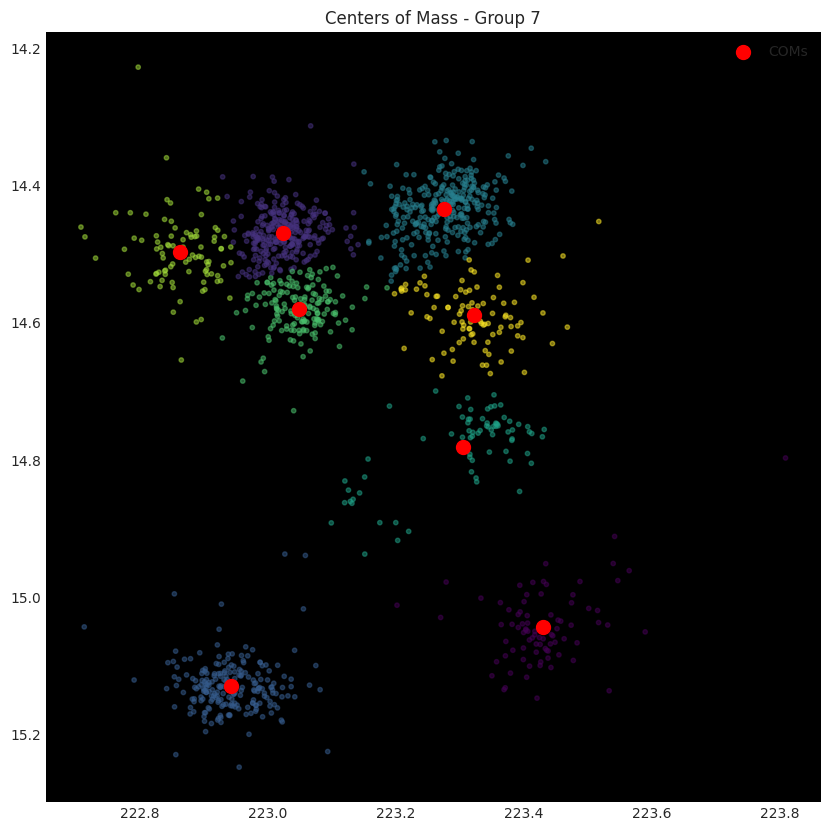

Minimum Bounding Rectangle:
 [[223.42997067  15.04475671]
 [223.32047752  14.41684872]
 [222.83197214  14.50203317]
 [222.94146529  15.12994116]]
Closest side of bounding rectangle:
 0
Closest line start: [223.42997067  15.04475671], end: [223.32047752  14.41684872]
Initial calculated angle: -1.7434381189476014 radians (-99.89164605792476 degrees)
Final rotation angle: 1.7434381189476014 radians (99.89164605792476 degrees)
Rotation angle:
 1.7434381189476014
Rotated Data:
 [[223.90506034  15.08182299]
 [223.87122488  15.07057912]
 [223.90710466  15.11323501]
 [223.8743313   15.08679573]
 [223.83568741  15.12996279]]
Rotated Centers of Mass (COM):
 [[223.43159415  15.04475671]
 [224.06735375  14.74306539]
 [223.42997067  14.54887982]
 [224.05793282  14.99671022]
 [223.71117214  14.96681735]
 [223.95345077  14.74887848]
 [224.06735375  14.57986748]
 [223.89799488  15.01567586]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.8850307725373945 radians (279.89164605792473 

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


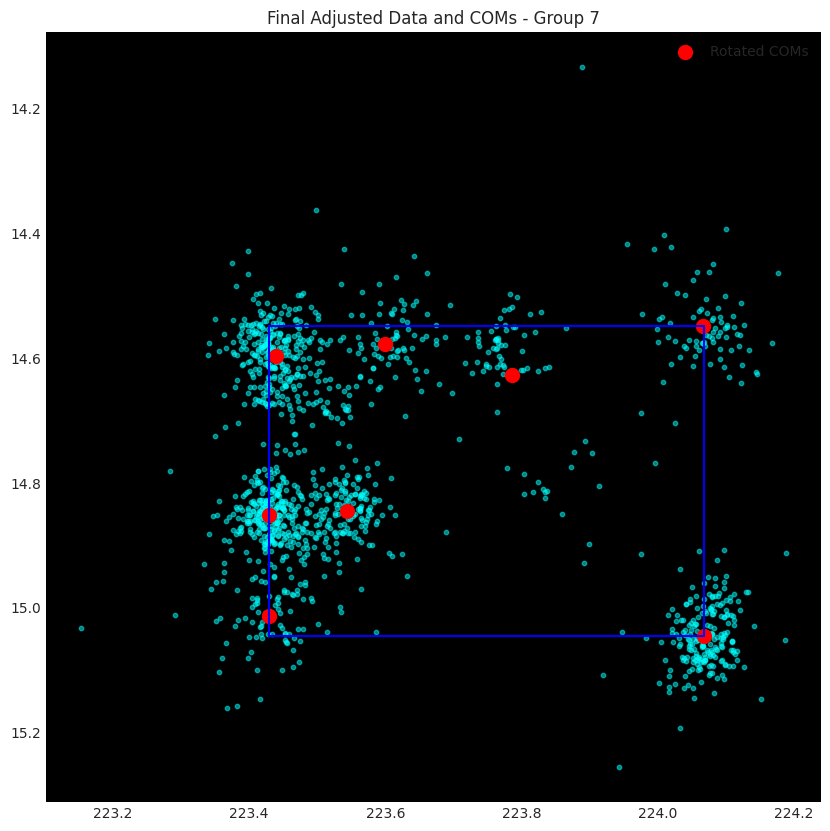

Second Highest COM:
 [223.42997067  14.85057114]
Right Most COM:
 [224.06735375  15.04475671]
Second Right Most COM:
 [224.06573027  14.54887982]
Robot COM:
 [223.54387365  14.84475804]


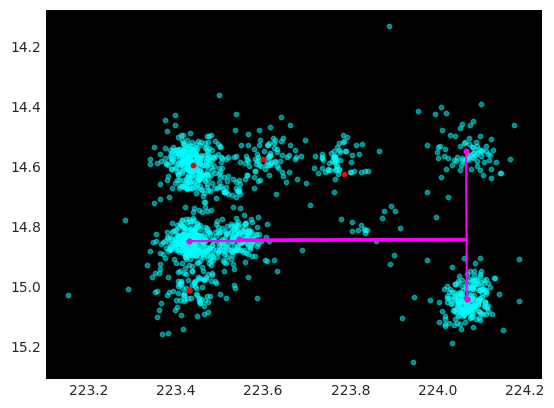

Ratio:
 0.8210875630767464

Processing Group 8
Data collected:
             x         y
0  237.977173  6.251901
1  238.027069  6.185611
2  238.016663  6.100646
3  238.483246  5.802577
4  238.440857  5.771270


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


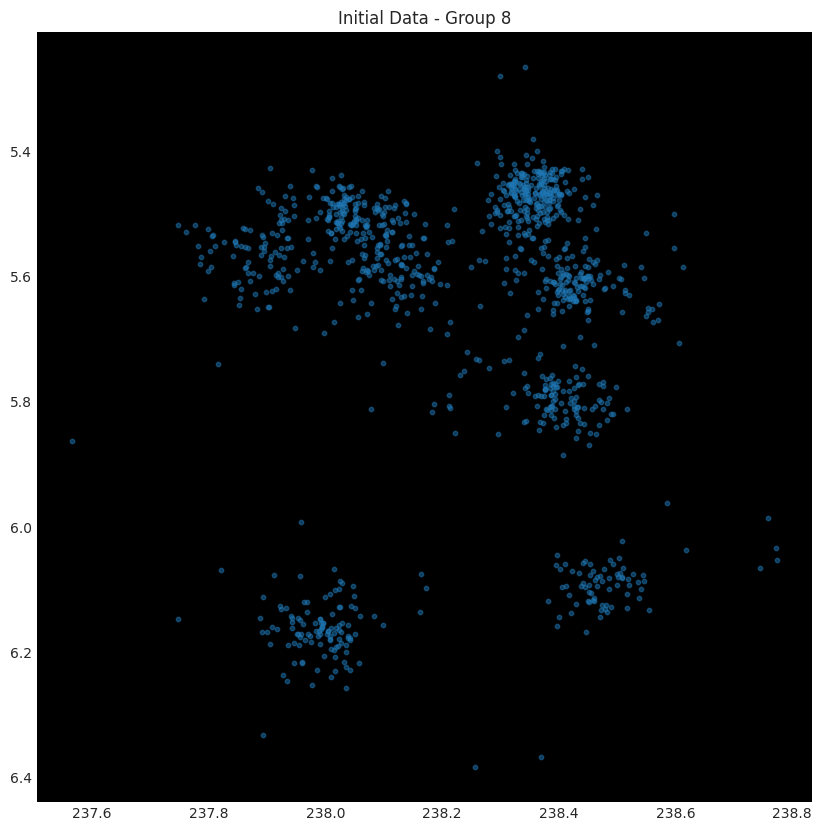

K-Means labels:
 [0 0 0 ... 7 7 7]


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


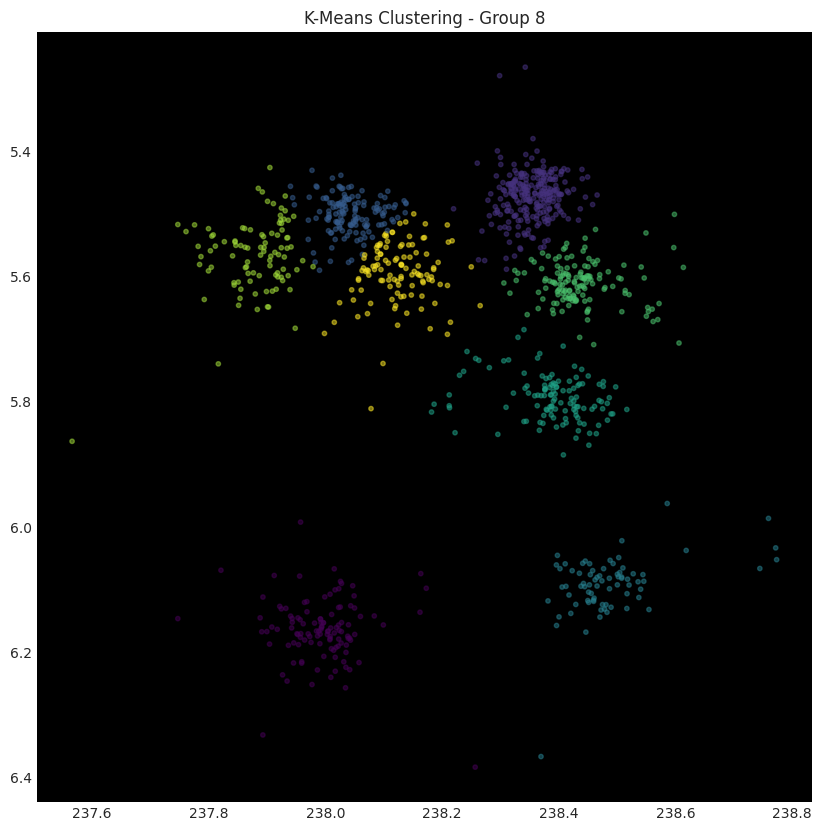

Centers of Mass (COM):
 [(np.float64(237.99338153341543), np.float64(6.164132669697637)), (np.float64(238.35425926831908), np.float64(5.4715285802165825)), (np.float64(238.04266151806988), np.float64(5.5008632105293005)), (np.float64(238.48725077311198), np.float64(6.092408180236816)), (np.float64(238.3882244519951), np.float64(5.793326519737559)), (np.float64(238.4365927956321), np.float64(5.611138427174175)), (np.float64(237.87888842130963), np.float64(5.566739684657047)), (np.float64(238.12560163225447), np.float64(5.594851306506565))]


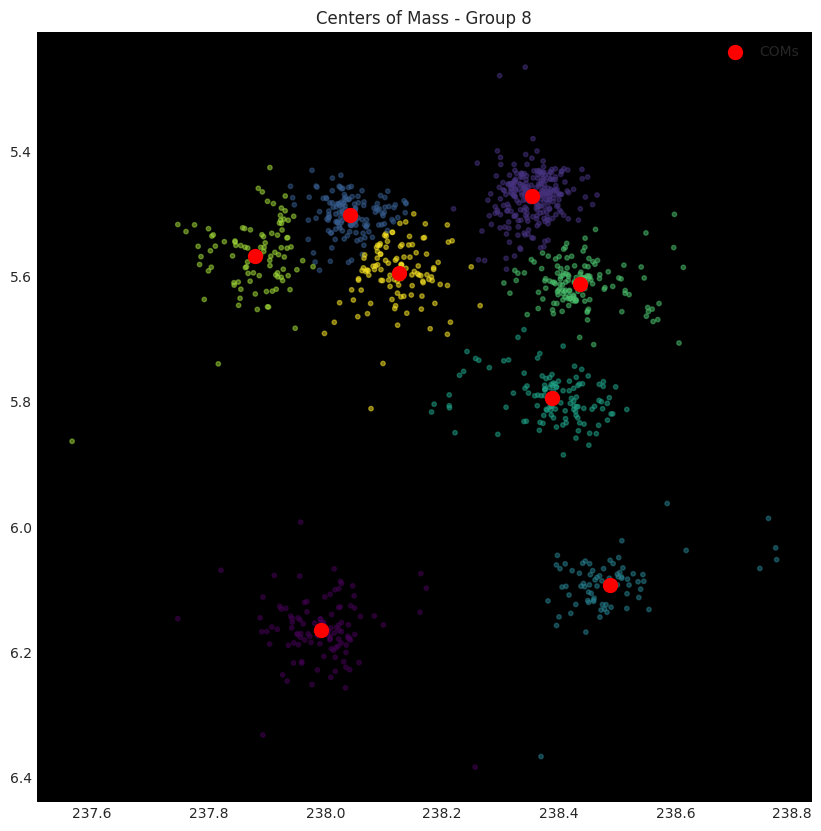

Minimum Bounding Rectangle:
 [[238.52735719   6.0847216 ]
 [238.40224983   5.43194646]
 [237.87251271   5.53347301]
 [237.99762007   6.18624816]]
Closest side of bounding rectangle:
 0
Closest line start: [238.52735719   6.0847216 ], end: [238.40224983   5.43194646]
Initial calculated angle: -1.760154735255414 radians (-100.849437620102 degrees)
Final rotation angle: 1.760154735255414 radians (100.849437620102 degrees)
Rotation angle:
 1.760154735255414
Rotated Data:
 [[238.46672695   5.51290378]
 [238.52244003   5.5743858 ]
 [238.60784532   5.58015823]
 [238.81276105   6.09450639]
 [238.85148748   6.05876809]]
Rotated Centers of Mass (COM):
 [[238.54987518   5.5453432 ]
 [239.16217152   6.03013836]
 [239.19201292   5.71858874]
 [238.52735719   6.04388524]
 [238.83973243   6.00292478]
 [239.00955963   6.0847216 ]
 [239.15814079   5.5453432 ]
 [239.08409312   5.78235505]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.901747388845207 radians (280.849437620102 degrees)

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


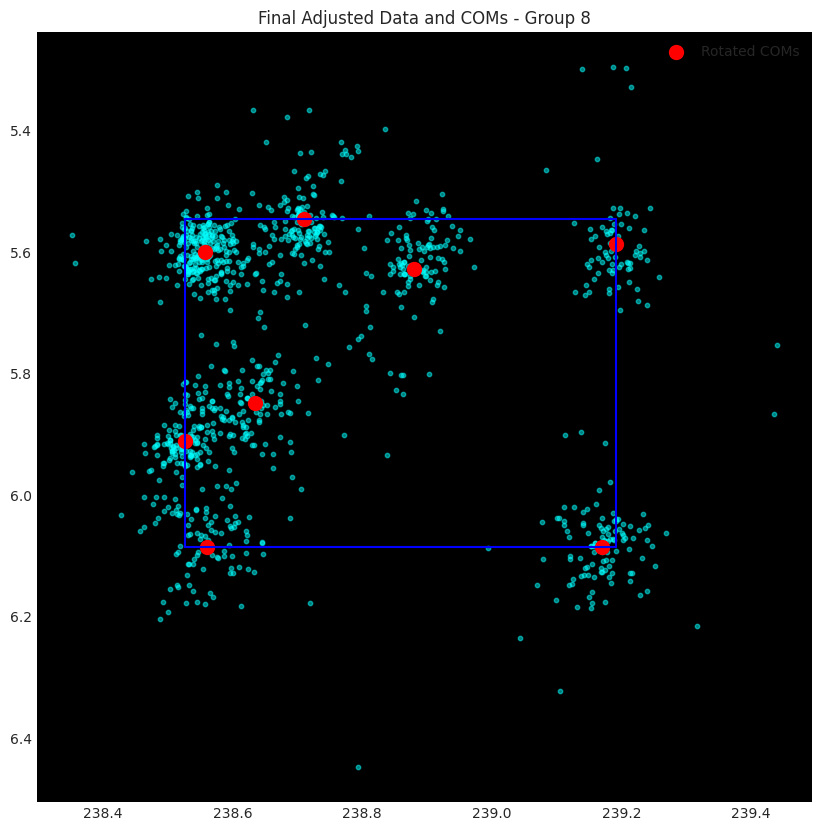

Second Highest COM:
 [238.52735719   5.91147607]
Right Most COM:
 [239.19201292   5.58617956]
Second Right Most COM:
 [239.16949493   6.0847216 ]
Robot COM:
 [238.63527699   5.84770976]


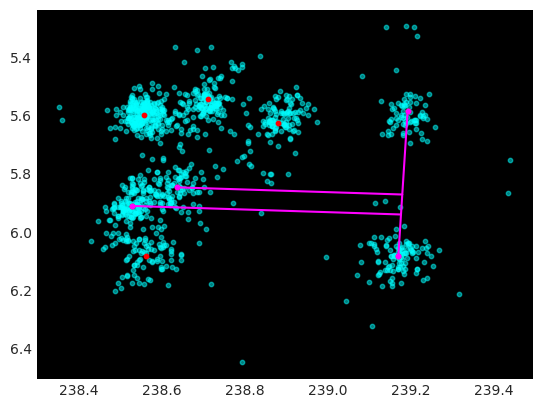

Ratio:
 0.8383913451003757

Processing Group 9
Data collected:
             x          y
0  204.727203  23.444227
1  204.673523  23.472221
2  204.732361  23.457150
3  204.768372  23.501686
4  205.214050  22.981375


/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


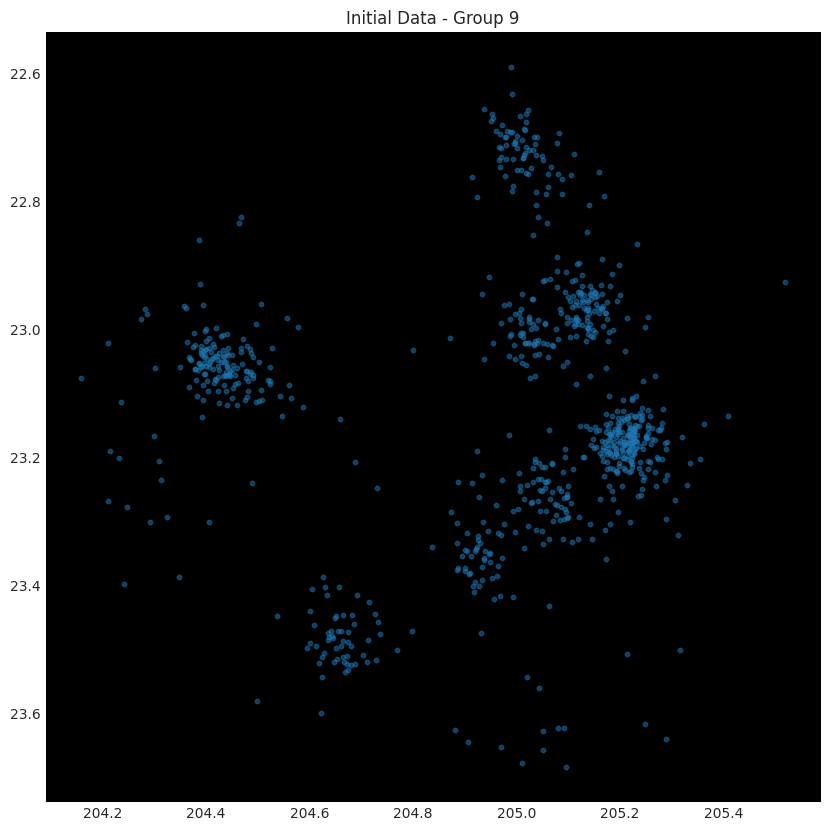

K-Means labels:
 [3 3 3 3 4 4 4 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 0 5 5 5 5 5 5 5 5 0 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 1 1 4 4 5 3 3 3 5 5 5 5 5 5 5 1 1 1 1
 1 1 7 7 4 4 4 5 0 5 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 0 0 0 0 0 1
 1 1 1 1 7 1 1 1 1 0 0 0 0 0 0 0 0 0 0 6 3 3 3 3 3 3 3 3 3 3 6 3 5 6 6 6 6
 6 6 6 6 6 6 6 6 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 1 4
 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 2 4 4 4 4 4 4 4 7 4 4 2 2 3 3 4 4 4 0
 0 1 1 1 1 1 1 1 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 4 4 4 3 3 3 3 1 1 1 1 1 1 1 2 2 2 3 3 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 7 1 2 2 2 3 3 3 2 2 2 2 2 5 5 5 5 4 4 0 0 0 0 4 0 7 1 1 1 1 1 1
 1 1 1 1 1 1 4 1 1 1 1 1 1 0 5 0 0 5 5 5 5 5 7 7 5 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 4 4 5 0 5 4 4 1 1 1 1 1
 1 1 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2
 2 2 2 2

/tmp/ipykernel_8556/2564005987.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


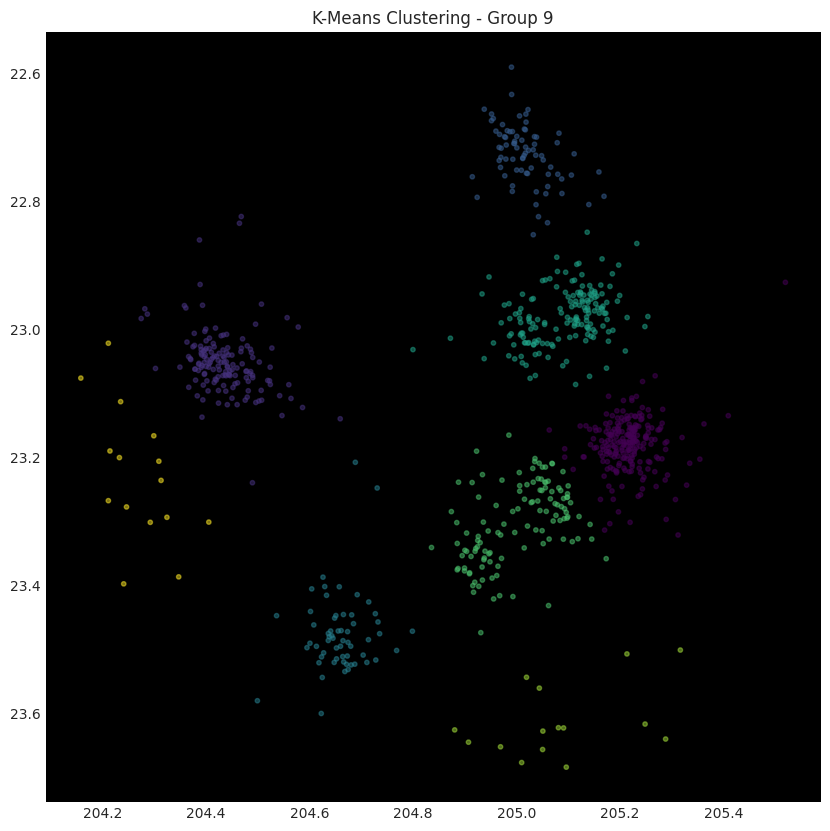

Centers of Mass (COM):
 [(np.float64(205.217156162346), np.float64(23.179604450511512)), (np.float64(204.43523579915365), np.float64(23.051091740926108)), (np.float64(205.01724604556435), np.float64(22.726969543256256)), (np.float64(204.6600561626887), np.float64(23.47455044116004)), (np.float64(205.0923733594941), np.float64(22.98025301026135)), (np.float64(205.00301615397134), np.float64(23.30264770189921)), (np.float64(205.08466186523438), np.float64(23.61215985616048)), (np.float64(204.26913045247395), np.float64(23.228938420613606))]


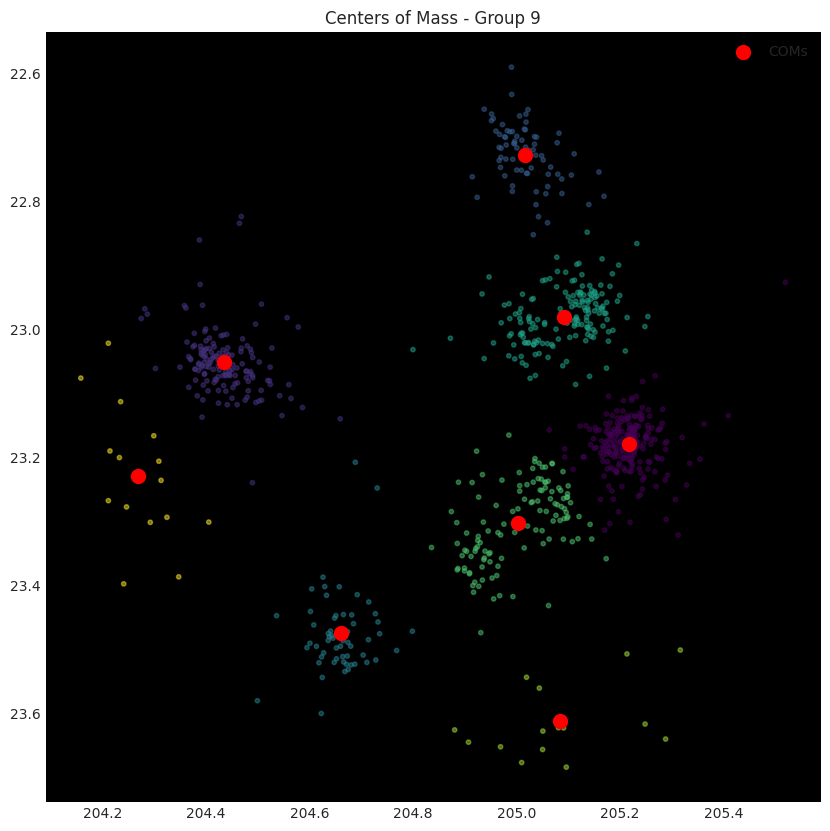

Minimum Bounding Rectangle:
 [[205.33786548  22.8308783 ]
 [204.48745745  22.55527166]
 [204.23425384  23.33655322]
 [205.08466187  23.61215986]]
Closest side of bounding rectangle:
 2
Closest line start: [204.23425384  23.33655322], end: [205.08466187  23.61215986]
Initial calculated angle: 0.3134063834332316 radians (17.956863043182974 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.4549990370230246 radians (197.95686304318298 degrees)
Final rotation angle: -3.4549990370230246 radians (-197.95686304318298 degrees)
Rotation angle:
 -3.4549990370230246
Rotated Data:
 [[203.73212043  23.3861009 ]
 [203.7745554   23.34292065]
 [203.72323024  23.37539813]
 [203.67524295  23.34413311]
 [203.41168618  23.97650266]]
Rotated Centers of Mass (COM):
 [[203.34761721  23.78888648]
 [204.13106995  23.67007246]
 [203.67733722  24.15784058]
 [203.78664815  23.33655322]
 [203.52778193  23.94005664]
 [203.51339188  23.60581725]
 [203.34030035  23.33655322]
 [204.23425384  23.44967847]]
Fin

/tmp/ipykernel_8556/3949580956.py:113: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


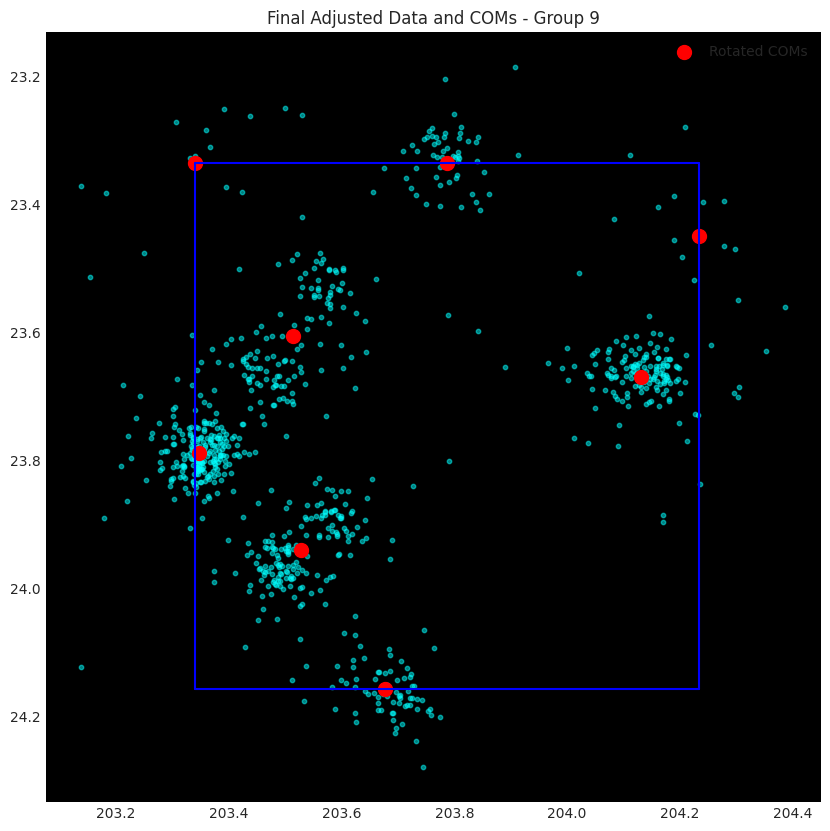

Second Highest COM:
 [203.51339188  23.60581725]
Right Most COM:
 [204.23425384  23.44967847]
Second Right Most COM:
 [204.13106995  23.67007246]
Robot COM:
 [203.51339188  23.60581725]


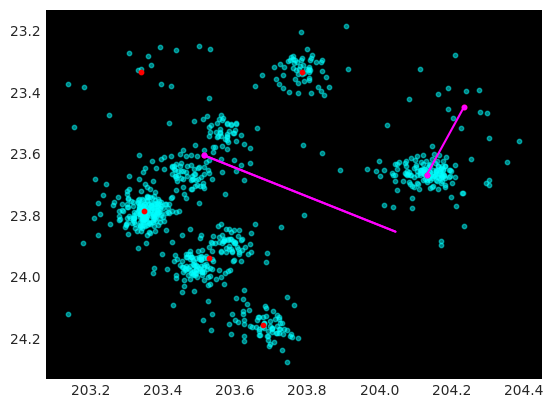

Ratio:
 1.0


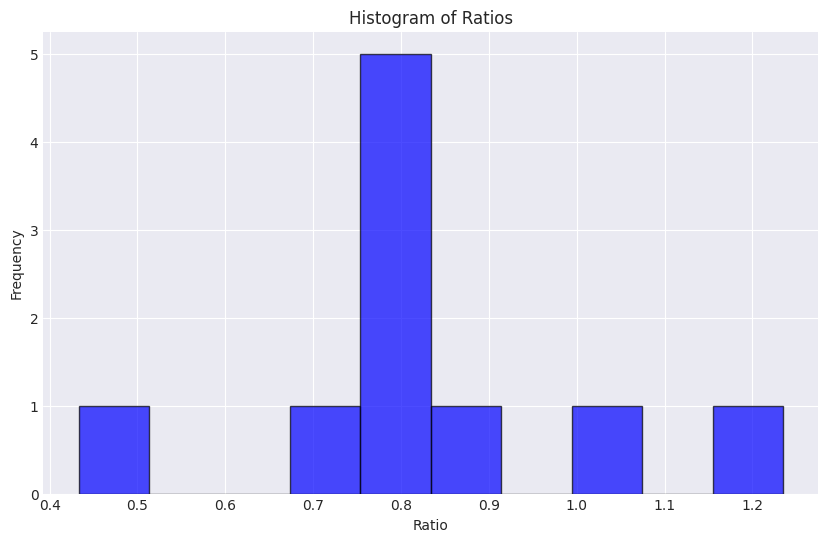

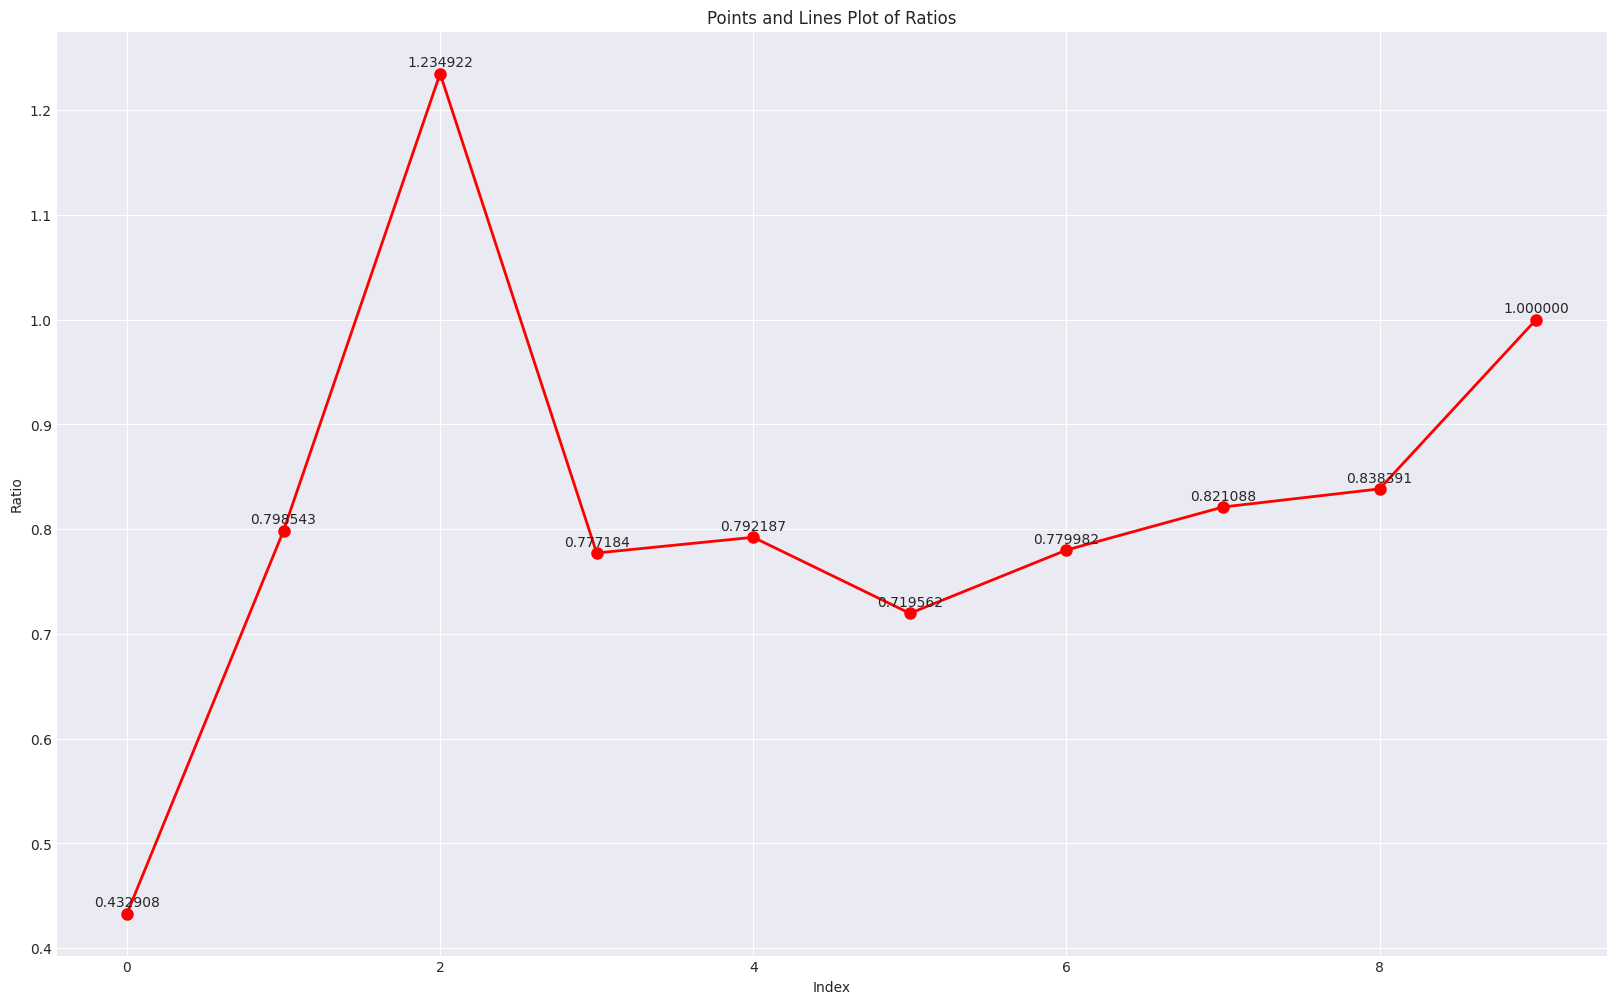

Mean Ratio: 0.8194767556742739
Standard Deviation: 0.19222225405225837


[np.float64(0.432907903695088),
 np.float64(0.7985430066741575),
 np.float64(1.234922341201315),
 np.float64(0.7771844927893748),
 np.float64(0.7921873542907827),
 np.float64(0.7195616600047895),
 np.float64(0.7799818899101107),
 np.float64(0.8210875630767464),
 np.float64(0.8383913451003757),
 np.float64(1.0)]

In [ ]:
# Example usage
filename = 'data/n=10_origmi_locs.hdf5'
k = 8
process_multiple_origami_ratio(filename, k)